# Domaine adversarial network for HH->bbtautau resonant analysis

## Motivations

The idea is based on two papers ( [G.Louppe et al.](https://arxiv.org/pdf/1611.01046), [L. Bradshaw et al.](https://arxiv.org/abs/1908.08959) ), showing that the use of DANN in scenarios where searching for resonances of unknown mass can prevent the effect known as 'mass sculpting'. This effect is a consequence of the typically large correlation between the resonance mass, as used in the classifier training (i.e. typically a single, arbitrary mass point), and the classifier output. This correlation, once learned, prevents the separation of signal from the background in the resonance mass range, and can heavily reduce the sensitivity to signal.

The method proposed here is to train a classifier against an adversary regressor. While the classifier is trained to yield an optimised separation between our signal and backgrounds, the adversary is trained in parallel to guess the event mass from the classifier output. The two networks are trained in a combined way, so that good performances of the regressor in the training process acts as a penality to the combined performances, while still being a reward for the adversary training.

This adversarial training, by decorrelating the classifier output from the resonance mass, could allow the definition of a single discriminant for the resonance search, that could be used either to define signal-enriched regions, or directly as a template for limit setting.

## Setting things up

In [3]:
# Fit notebook to browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ML packages: 
import tensorflow as tf
print('TensorFlow version ', tf.__version__)

import keras
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Input, concatenate, Lambda, Dropout
from keras.models import Sequential, load_model, Model
from keras.optimizers import Adam, SGD, RMSprop

from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from scipy import stats, interpolate

# ROOT
import ROOT
from root_numpy import tree2array

# Basic utilities
import numpy as np
import pandas as pd

# Plotting utilities
import seaborn as sns
import pickle
import matplotlib
import matplotlib.pyplot as plt

from scipy import stats

TensorFlow version  2.3.0
Welcome to JupyROOT 6.22/02


## Retrieving data

### Input variables
The input list here is temporary. It'll be improved and/or updated according to the Parametrised network developed by Gilles Strong in parallel, for benchmarking or potential method association (feasability to be discussed)

In [32]:
### List of branches in root files:
allBranches = {
    'HHKin_mass_raw',
    'mT1',
    'mT2',
    'dau1_pt',
    'dau1_decayMode',
    'dau2_decayMode',
    'bjet1_pt',
    'bjet1_CvsL',
    'bjet1_CvsB',
    'tauH_SVFIT_mass',
    'tauHsvfitMet_deltaPhi',
    'ditau_deltaR',
    'bH_mass',
    'HHKin_chi2',
    'HHsvfit_deltaPhi',
    'ditau_deltaR_per_tauH_MET_pt',
    'DNNoutSM_kl_1'
}

### List of NN inputs
inFeatures = {
    'HHKin_mass_raw',
    'mT1',
    'mT2',
    'dau1_pt',
    'dau1_decayMode',
    'dau2_decayMode',
    'bjet1_pt',
    'bjet1_CvsL',
    'bjet1_CvsB',
    'tauH_SVFIT_mass',
    'tauHsvfitMet_deltaPhi',
    'ditau_deltaR',
    'bH_mass',
    'HHKin_chi2',
    'HHsvfit_deltaPhi',
    'ditau_deltaR_per_tauH_MET_pt',
    #'DNNoutSM_kl_1'
}

### Mass binning optimizer

In [33]:
def get_opt_binning(df_in):

    ##### print optimal binning (20 bins):
    #mass_bins_setup = df.HHKin_mass_raw.to_numpy()
    #mass_bins_setup = np.sort(mass_bins_setup)
    #size = int(len(mass_bins_setup) / 20 )
    #massbins = [0 , #[-50 - 1e-5,
    #            mass_bins_setup[size], mass_bins_setup[size * 2],
    #            mass_bins_setup[size * 3], mass_bins_setup[size * 4],
    #            mass_bins_setup[size * 5], mass_bins_setup[size * 6],
    #            mass_bins_setup[size * 7], mass_bins_setup[size * 8],
    #            mass_bins_setup[size * 9], mass_bins_setup[size *10], 
    #            mass_bins_setup[size *11], mass_bins_setup[size *12],
    #            mass_bins_setup[size *13], mass_bins_setup[size *14],
    #            mass_bins_setup[size *15], mass_bins_setup[size *16],
    #            mass_bins_setup[size *17], mass_bins_setup[size *18],
    #            mass_bins_setup[size *19],
    #            3500 + 1e-5]
    
    
    ##### print optimal binning (10 bins):
    #mass_bins_setup = df_in.HHKin_mass_raw.to_numpy()
    #print(mass_bins_setup)
#    mass_bins_setup = np.sort(mass_bins_setup)
    #print(mass_bins_setup)
    #size = int(len(mass_bins_setup) / 10 )
    #massbins = [0 , #[-50 - 1e-5,
    #            mass_bins_setup[size], mass_bins_setup[size * 2],
    #            mass_bins_setup[size * 3], mass_bins_setup[size * 4],
    #            mass_bins_setup[size * 5], mass_bins_setup[size * 6],
    #            mass_bins_setup[size * 7], mass_bins_setup[size * 8],
    #            mass_bins_setup[size * 9],
    #            3500 + 1e-5]

    ##### print optimal binning (3 bins):
    #mass_bins_setup = df.HHKin_mass_raw.to_numpy()
    #mass_bins_setup = np.sort(mass_bins_setup)
    #size = int(len(mass_bins_setup) / 3 )
    #massbins = [0 , #[-50 - 1e-5,
    #            mass_bins_setup[size], mass_bins_setup[size * 2],
    #            3500 + 1e-5]
    #print(massbins)
    
    
    min_mass, max_mass = np.min(df_in.HHKin_mass_raw.to_numpy()), np.max(df_in.HHKin_mass_raw.to_numpy())
    diff = max_mass - min_mass
    min_mass, max_mass = min_mass - 0.01*diff, max_mass + 0.01*diff
    
    # split in 50 bins
    massbins = np.linspace(min_mass,max_mass,21)
    print(massbins)
    return massbins

### Data loader

Takes a root file as an input, and returns well-formatted arrays for the NN training and testing

In [34]:
def get_planing_weight(mass_dist):

    print(mass_dist)
    # Retrieve upper and lower bounds
    min_mass, max_mass = np.min(mass_dist), np.max(mass_dist)
    diff = max_mass - min_mass
    min_mass, max_mass = min_mass - 0.10*diff, max_mass + 0.10*diff
    
    # split in thin bins
    nbins = np.linspace(min_mass,max_mass,1000)
    print(nbins)
    # get bins centers
    masspts = 0.5*(nbins[1:] + nbins[:-1])  
    
    # get fraction of entries per bin
    vals, _ = np.histogram(mass_dist, bins=nbins, density=True)  
    
    # interpolate
    interp = interpolate.interp1d(masspts, vals, bounds_error=False)   
    
    # Weight = (sum(mass)/(mass))/<sum(mass)/(mass)>
    probs= interp(mass_dist)    
    weights = np.nansum(probs)/probs
    weights/=np.nanmean(weights) 
    print(weights.shape)
    return weights
    

In [35]:
def load_data(inFile, savedBranches, inFeatures, isSig=True, preproc=False):
    '''
    Inputs:
        inFile: input root file location
        savedBranches: list of TTree branches to retrieve
        inFeatures: list of TTree branches that are NN input features
        isSig: 0: signal, 1: background (default = 1)
    Outputs:
        X_train: numpy array of training data scaled and centered
        y_train: training labels for base DNN
        m_train: training mass bins for adversary 
        X_test: numpy array of validation data scaled and centered
        y_test: validation labels
        m_test: validation mass bins for adversary
    '''
    #### Input TTree to np array
    rfile = ROOT.TFile(inFile)
    intree = rfile.Get('HTauTauTree')
    arr = tree2array(intree,branches=savedBranches)

    #### np array to panda dataframes
    df = pd.DataFrame(arr)
    df = df[df.HHKin_mass_raw > 0]
    df = df[df.HHKin_mass_raw < 1500]
        
    #### add label column
    df.insert(0,'Class', int(isSig), True)

    #### Print optimal mass binning for background
    if not isSig:
        print(get_opt_binning(df))
    
    #### Define mass bins for adversary
    #HHmass = pd.cut(df.HHKin_mass_raw, bins=[-1, 293, 350, 99999], labels=range(3))
    #HHmass = pd.cut(df.HHKin_mass_raw, bins=[-1, 329, 402, 488, 624, 99999], labels=range(5))
    #HHmass = pd.cut(df.HHKin_mass_raw, bins=[-1, 265, 277, 289, 302, 317, 335, 358, 394, 459, 99999], labels=range(10))
    HHmass = pd.cut(df.HHKin_mass_raw, bins=[-1, 258, 265, 271, 277, 283, 289, 295, 302, 309, 317, 325, 335, 346, 358, 374, 394, 420, 459, 531, 999999], labels=range(20))
    #HHmass = pd.cut(df.HHKin_mass_raw, bins=[ 220.59094727, 370.59144116, 520.59193506, 670.59242896, 820.59292285, 970.59341675, 1120.59391064, 1270.59440454, 1420.59489844, 1570.59539233, 1720.59588623, 1870.59638013, 2020.59687402, 2170.59736792, 2320.59786182, 2470.59835571, 2620.59884961, 2770.59934351, 2920.5998374, 3070.6003313, 3220.6008252 ], labels=range(20))
    #HHmass = pd.cut(df.HHKin_mass_raw, bins=[0, 282.34015, 309.4519, 338.89114, 372.67288, 409.9984, 451.6099, 504.37173, 578.64056, 703.4415, 3500.00001], labels=range(10)) ### OTHER background
    #### Split dataframe
    df_labels = df['Class']
    df_features = df[ inFeatures ]
    df_features = df_features.reindex(columns= inFeatures)
    df_NNana = df[ 'DNNoutSM_kl_1' ]

    #### Flatten labels
    ravel_labels=np.ravel(df_labels)
    ravel_HHmass=np.ravel(HHmass)
    flat_w = get_planing_weight(np.array(df_features[ 'HHKin_mass_raw' ]))
    
    #### test/train splitting:
    X_train, X_test, y_train, y_test, m_train, m_test, w_train, w_test = train_test_split(df_features, ravel_labels, ravel_HHmass, flat_w, test_size=0.2, random_state=42)
    
    print(X_train.shape, w_train.shape)
    
    #### get list of variable names, for display purpose #only
    var_name = list(X_train) 
    
    #### Feature pre-processing 
    if preproc:
        #scaler = StandardScaler().fit(X_train)
        scaler = MinMaxScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    return X_train, y_train, m_train, w_train, X_test, y_test, m_test, w_test, var_name,

### Prepare working directory

In [36]:
import os,sys

data_dir = '/data_CMS/cms/portales/HHresonant_SKIMS/trimmed_samples/'
work_dir = '/data_CMS/cms/portales/HHresonant_DANN/'

if not os.path.exists(work_dir):
    os.mkdir(work_dir)
    
if not os.path.exists(work_dir+'models/'):
    os.mkdir(work_dir+'models/')

if not os.path.exists(work_dir+'models/base_classifier/'):
    os.mkdir(work_dir+'models/base_classifier/')
    
if not os.path.exists(work_dir+'models/base_adversary/'):
    os.mkdir(work_dir+'models/base_adversary/')
    
if not os.path.exists(work_dir+'models/combined_classifier/'):
    os.mkdir(work_dir+'models/combined_classifier/')
    
if not os.path.exists(work_dir+'models/combined_classifier/tmp/'):
    os.mkdir(work_dir+'models/combined_classifier/tmp/')
    
if not os.path.exists(work_dir+'metrics/'):
    os.mkdir(work_dir+'metrics/')

### Retrieve data

Currently: ttbar background vs single signal mass point

- **M = 900 GeV** - ***savedModel = ''*** :

    - Great improvements from DANN for m=350 GeV and above
    - 250 GeV mass point improves, but still low
    
- **M = 450 GeV** - ***savedModel = ''***:

    - DANN performs great for training mass and higher
    - Improved performance for lower masses but still not great for M~250 GeV (could be improved)
    
- **M = 250 GeV** - ***savedModel = 'combined_nn_benchmark_m250_10bins_v1'***:

    - Large improvement from DANN wrt base NN for all tested mass points
    - Still relatively low performance overall, except for training mass point
    
- **M = 250 GeV + 450 GeV** - ***savedModel = 'combined_nn_benchmark_m250450_10bins_v1'***:

    - Comparable performance for training mass point between 'base' and DANN networks
    - Mild mprovement seen for M = 350 GeV signal, not clear for higher mass points
    
Mass binning was not optimal, fixing it and running tests below:

- **M = 450 GeV** - ***savedModel = ''***:


[ 237.52062744  301.17974634  364.83886523  428.49798413  492.15710303
  555.81622192  619.47534082  683.13445972  746.79357861  810.45269751
  874.11181641  937.7709353  1001.4300542  1065.0891731  1128.74829199
 1192.40741089 1256.06652979 1319.72564868 1383.38476758 1447.04388647
 1510.70300537]
[ 237.52062744  301.17974634  364.83886523  428.49798413  492.15710303
  555.81622192  619.47534082  683.13445972  746.79357861  810.45269751
  874.11181641  937.7709353  1001.4300542  1065.0891731  1128.74829199
 1192.40741089 1256.06652979 1319.72564868 1383.38476758 1447.04388647
 1510.70300537]
[272.01215 602.5987  429.66315 ... 363.04333 376.07047 295.79852]
[ 125.18100586  126.68036684  128.17972782  129.67908881  131.17844979
  132.67781077  134.17717175  135.67653273  137.17589372  138.6752547
  140.17461568  141.67397666  143.17333764  144.67269863  146.17205961
  147.67142059  149.17078157  150.67014255  152.16950354  153.66886452
  155.1682255   156.66758648  158.16694747  159.666

(3139100,)
(2511280, 16) (2511280,)
[250.86166 252.03642 251.94637 ... 895.56116 837.0963  989.6833 ]
[ 125.0356781   126.53678019  128.03788229  129.53898438  131.04008648
  132.54118857  134.04229066  135.54339276  137.04449485  138.54559695
  140.04669904  141.54780113  143.04890323  144.55000532  146.05110742
  147.55220951  149.0533116   150.5544137   152.05551579  153.55661788
  155.05771998  156.55882207  158.05992417  159.56102626  161.06212835
  162.56323045  164.06433254  165.56543464  167.06653673  168.56763882
  170.06874092  171.56984301  173.07094511  174.5720472   176.07314929
  177.57425139  179.07535348  180.57645558  182.07755767  183.57865976
  185.07976186  186.58086395  188.08196605  189.58306814  191.08417023
  192.58527233  194.08637442  195.58747651  197.08857861  198.5896807
  200.0907828   201.59188489  203.09298698  204.59408908  206.09519117
  207.59629327  209.09739536  210.59849745  212.09959955  213.60070164
  215.10180374  216.60290583  218.10400792  219

(278290, 16) (278290, 16)
['HHKin_mass_raw', 'HHKin_chi2', 'dau1_pt', 'ditau_deltaR', 'bH_mass', 'tauH_SVFIT_mass', 'dau2_decayMode', 'dau1_decayMode', 'HHsvfit_deltaPhi', 'mT1', 'bjet1_CvsB', 'ditau_deltaR_per_tauH_MET_pt', 'bjet1_CvsL', 'tauHsvfitMet_deltaPhi', 'mT2', 'bjet1_pt']


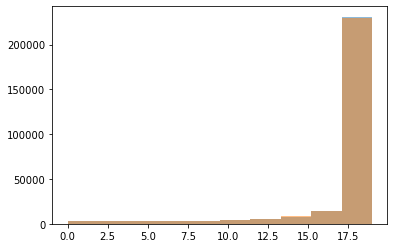

(556580, 16)

In [37]:
mass_point = 'All' # Resonance mass in GeV

#### Input files
sig_in = data_dir + 'Radion' + mass_point + '_allperiods_resDNN_selfix.root'
#sig_in = data_dir + 'Radion' + mass_point + '_2018_allperiods_resDNN_selfix.root'
bkg_in = data_dir + 'TT_all_sel.root'
#bkg_in = data_dir + 'other_18_sel.root'

X_train_bkg, y_train_bkg, m_train_bkg, w_train_bkg, X_test_bkg, y_test_bkg, m_test_bkg, w_test_bkg, var_name_bkg = load_data(bkg_in, allBranches, inFeatures, isSig = False , preproc = True)
X_train_sig, y_train_sig, m_train_sig, w_train_sig, X_test_sig, y_test_sig, m_test_sig, w_test_sig, var_name_sig = load_data(sig_in, allBranches, inFeatures, isSig = True  , preproc = True)

#### Bkg random downsampling
indices = np.random.permutation(len(X_train_bkg))
print(indices)
X_train_bkg = X_train_bkg[indices]
y_train_bkg = y_train_bkg[indices]
m_train_bkg = m_train_bkg[indices]
w_train_bkg = w_train_bkg[indices]

X_train_bkg = X_train_bkg[:len(X_train_sig)]
y_train_bkg = y_train_bkg[:len(X_train_sig)]
m_train_bkg = m_train_bkg[:len(X_train_sig)]
w_train_bkg = w_train_bkg[:len(X_train_sig)]

print(X_train_sig.shape, X_train_bkg.shape)
print(var_name_sig)

#### Merge signal/background
X_train = np.concatenate((X_train_sig,X_train_bkg))
y_train = np.concatenate((y_train_sig,y_train_bkg))
m_train = np.concatenate((m_train_sig,m_train_bkg))

X_test = np.concatenate((X_test_sig,X_test_bkg))
y_test = np.concatenate((y_test_sig,y_test_bkg))
m_test = np.concatenate((m_test_sig,m_test_bkg))

#### Compute weight vector to balance Sig & Bkg
Weight = float(len(y_train[np.ravel(y_train == 0)]))/float(len(y_train[np.ravel(y_train == 1)]))
Weights = (np.ones_like(y_train) - y_train) * Weight + np.ones_like(y_train)*y_train
#print(Weight)
Weights = dict([(0, 1.), (1, Weight)])
dummyWeights = dict([(0,1.), (1,1.)])

weights_sig = w_train_sig
weights_bkg = w_train_bkg*(np.sum(w_train_bkg))/np.sum(w_train_sig)
sampleWeights = np.concatenate((weights_sig,weights_bkg))

weights_test_sig = w_test_sig
weights_test_bkg = w_test_bkg*(np.sum(w_test_bkg))/np.sum(w_test_sig)
sampleWeights_test = np.concatenate((weights_test_sig,weights_test_bkg))

plt.hist(m_train_sig, weights=Weights[0]*w_train_sig, alpha=0.5, bins=10)
plt.hist(m_train_bkg, weights=Weights[1]*w_train_bkg, alpha=0.5, bins=10)
plt.show()
X_train.shape

### Input features drawing

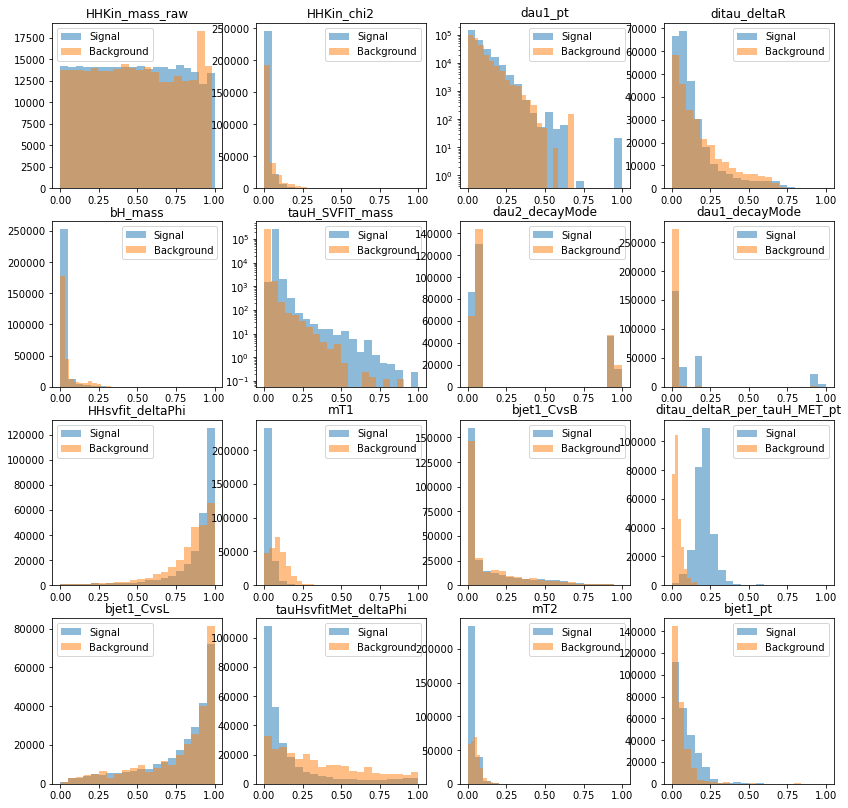

In [38]:
#### Draw input features

fig, axs = plt.subplots(4, 4,figsize=(14,14))

#weights_sig = np.ones_like(X_train_sig[:,0]) / float(len(X_train_sig))
#weights_bkg = np.ones_like(X_train_bkg[:,0]) / float(len(X_train_bkg))

axs[0,0].hist(X_train_sig[:,0],bins=20, alpha=0.5, weights=weights_sig)
axs[0,0].hist(X_train_bkg[:,0],bins=20, alpha=0.5, weights=weights_bkg)
axs[0,0].legend(['Signal', 'Background'], loc='best')
axs[0,0].set_title(var_name_sig[0])

axs[0,1].hist(X_train_sig[:,1],bins=20, alpha=0.5, weights=weights_sig)
axs[0,1].hist(X_train_bkg[:,1],bins=20, alpha=0.5, weights=weights_bkg)
axs[0,1].legend(['Signal', 'Background'], loc='best')
axs[0,1].set_title(var_name_sig[1])

axs[0,2].hist(X_train_sig[:,2],bins=20, alpha=0.5, weights=weights_sig)
axs[0,2].hist(X_train_bkg[:,2],bins=20, alpha=0.5, weights=weights_bkg)
axs[0,2].legend(['Signal', 'Background'], loc='best')
axs[0,2].set_yscale('log')
axs[0,2].set_title(var_name_sig[2])

axs[0,3].hist(X_train_sig[:,3],bins=20, alpha=0.5, weights=weights_sig)
axs[0,3].hist(X_train_bkg[:,3],bins=20, alpha=0.5, weights=weights_bkg)
axs[0,3].legend(['Signal', 'Background'], loc='best')
axs[0,3].set_title(var_name_sig[3])


axs[1,0].hist(X_train_sig[:,4],bins=20, alpha=0.5, weights=weights_sig)
axs[1,0].hist(X_train_bkg[:,4],bins=20, alpha=0.5, weights=weights_bkg)
axs[1,0].legend(['Signal', 'Background'], loc='best')
axs[1,0].set_title(var_name_sig[4])

axs[1,1].hist(X_train_sig[:,5],bins=20, alpha=0.5, weights=weights_sig)
axs[1,1].hist(X_train_bkg[:,5],bins=20, alpha=0.5, weights=weights_bkg)
axs[1,1].legend(['Signal', 'Background'], loc='best')
axs[1,1].set_yscale('log')
axs[1,1].set_title(var_name_sig[5])

axs[1,2].hist(X_train_sig[:,6],bins=20, alpha=0.5, weights=weights_sig)
axs[1,2].hist(X_train_bkg[:,6],bins=20, alpha=0.5, weights=weights_bkg)
axs[1,2].legend(['Signal', 'Background'], loc='best')
axs[1,2].set_title(var_name_sig[6])

axs[1,3].hist(X_train_sig[:,7],bins=20, alpha=0.5, weights=weights_sig)
axs[1,3].hist(X_train_bkg[:,7],bins=20, alpha=0.5, weights=weights_bkg)
axs[1,3].legend(['Signal', 'Background'], loc='best')
axs[1,3].set_title(var_name_sig[7])


axs[2,0].hist(X_train_sig[:,8],bins=20, alpha=0.5, weights=weights_sig)
axs[2,0].hist(X_train_bkg[:,8],bins=20, alpha=0.5, weights=weights_bkg)
axs[2,0].legend(['Signal', 'Background'], loc='best')
axs[2,0].set_title(var_name_sig[8])

axs[2,1].hist(X_train_sig[:,9],bins=20, alpha=0.5, weights=weights_sig)
axs[2,1].hist(X_train_bkg[:,9],bins=20, alpha=0.5, weights=weights_bkg)
axs[2,1].legend(['Signal', 'Background'], loc='best')
axs[2,1].set_title(var_name_sig[9])

axs[2,2].hist(X_train_sig[:,10],bins=20, alpha=0.5, weights=weights_sig)
axs[2,2].hist(X_train_bkg[:,10],bins=20, alpha=0.5, weights=weights_bkg)
axs[2,2].legend(['Signal', 'Background'], loc='best')
axs[2,2].set_title(var_name_sig[10])

axs[2,3].hist(X_train_sig[:,11],bins=20, alpha=0.5, weights=weights_sig)
axs[2,3].hist(X_train_bkg[:,11],bins=20, alpha=0.5, weights=weights_bkg)
axs[2,3].legend(['Signal', 'Background'], loc='best')
axs[2,3].set_title(var_name_sig[11])


axs[3,0].hist(X_train_sig[:,12],bins=20, alpha=0.5, weights=weights_sig)
axs[3,0].hist(X_train_bkg[:,12],bins=20, alpha=0.5, weights=weights_bkg)
axs[3,0].legend(['Signal', 'Background'], loc='best')
axs[3,0].set_title(var_name_sig[12])

axs[3,1].hist(X_train_sig[:,13],bins=20, alpha=0.5, weights=weights_sig)
axs[3,1].hist(X_train_bkg[:,13],bins=20, alpha=0.5, weights=weights_bkg)
axs[3,1].legend(['Signal', 'Background'], loc='best')
axs[3,1].set_title(var_name_sig[13])

axs[3,2].hist(X_train_sig[:,14],bins=20, alpha=0.5, weights=weights_sig)
axs[3,2].hist(X_train_bkg[:,14],bins=20, alpha=0.5, weights=weights_bkg)
axs[3,2].legend(['Signal', 'Background'], loc='best')
axs[3,2].set_title(var_name_sig[14])

axs[3,3].hist(X_train_sig[:,15],bins=20, alpha=0.5, weights=weights_sig)
axs[3,3].hist(X_train_bkg[:,15],bins=20, alpha=0.5, weights=weights_bkg)
axs[3,3].legend(['Signal', 'Background'], loc='best')
axs[3,3].set_title(var_name_sig[15])

plt.show()

### Draw correlation matrix

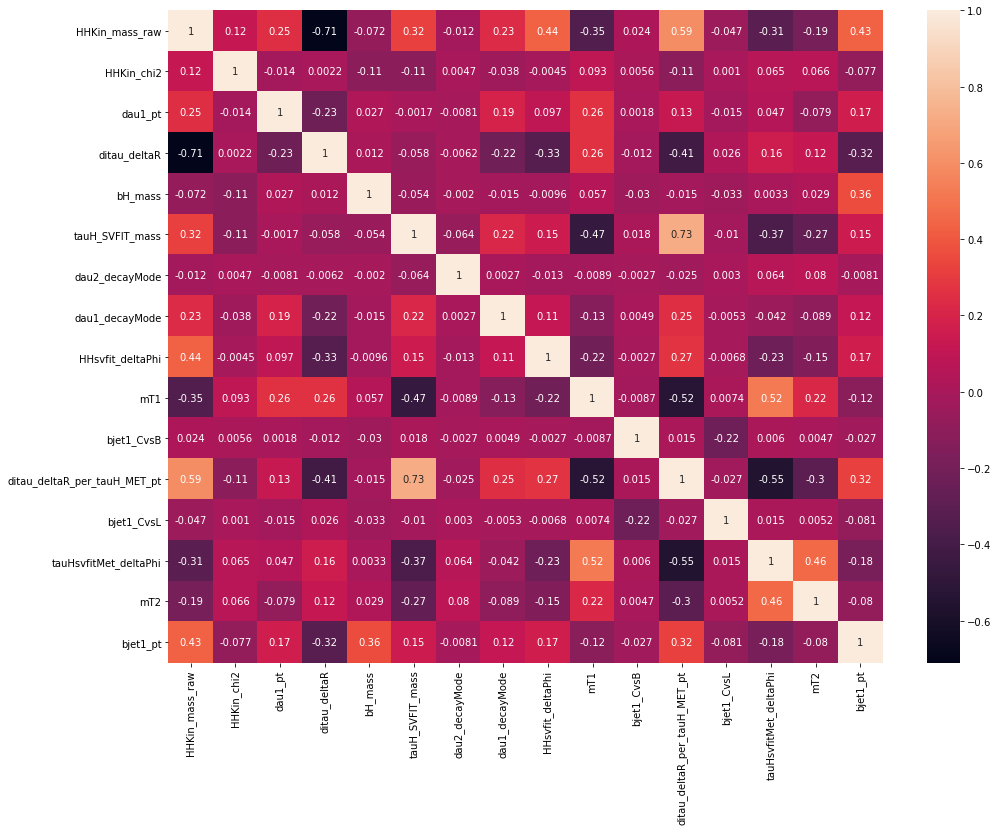

In [39]:
df_X_train = pd.DataFrame(X_train)

corr_sig = df_X_train.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_sig, annot=True, xticklabels=var_name_sig, yticklabels=var_name_sig)
plt.show()

## Base classifier training

We first create a basic DNN, and train it. The resonance mass is one of the input features, so we do expect this classifier's output to be highly correlated to the mass.

### Parameters

In [40]:
cla_nLayers = 3
cla_nodePerLayer = 64
cla_activation = 'relu'
cla_dropout = 0.2

nEpoch_base = 50

loss_base = 'binary_crossentropy'
optimizer_base = 'adam'
#early-stopping
esMonitor='val_loss'
esPatience=15

reduce_lr = ReduceLROnPlateau(monitor=esMonitor, factor=0.8, verbose=1,
                              patience=2, min_lr=1.0e-5)
es = EarlyStopping(monitor=esMonitor, patience=esPatience, verbose=0, mode='auto')


### Network definition

In [41]:
inputs = Input(shape=(X_train.shape[1], ))

Classifier = Dense(cla_nodePerLayer, activation=cla_activation)(inputs)
Classifier = Dropout(cla_dropout)(Classifier)
for i in range(cla_nLayers-1):   
    Classifier = Dense(cla_nodePerLayer+ (cla_nodePerLayer)*(i<cla_nLayers and i>0), activation=cla_activation)(Classifier)
    Classifier = Dropout(cla_dropout)(Classifier)
Classifier = Dense(1, activation='sigmoid')(Classifier)

ClassifierModel = Model(inputs=inputs, outputs=Classifier, name='Classifier')

ClassifierModel.compile(optimizer=Adam(lr=10e-4), loss=loss_base, metrics=['binary_accuracy'])
ClassifierModel.summary()

Model: "Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                1088      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0

### Network training

In [42]:
history = ClassifierModel.fit(X_train, y_train,
                              validation_data=(X_test, y_test),
                              epochs=700,#nEpoch_base,
                              shuffle=True,
                              sample_weight=sampleWeights,
                              callbacks=[reduce_lr, es],
                              batch_size=4096                              
                              )

Epoch 1/700
136/136 [==============================] - 1s 9ms/step - loss: 0.4627 - binary_accuracy: 0.7836 - val_loss: 0.1277 - val_binary_accuracy: 0.9806
Epoch 2/700
136/136 [==============================] - 1s 7ms/step - loss: 0.0893 - binary_accuracy: 0.9557 - val_loss: 0.0512 - val_binary_accuracy: 0.9896
Epoch 3/700
136/136 [==============================] - 1s 7ms/step - loss: 0.0382 - binary_accuracy: 0.9794 - val_loss: 0.0339 - val_binary_accuracy: 0.9911
Epoch 4/700
136/136 [==============================] - 1s 7ms/step - loss: 0.0305 - binary_accuracy: 0.9841 - val_loss: 0.0464 - val_binary_accuracy: 0.9878
Epoch 5/700
136/136 [==============================] - 1s 7ms/step - loss: 0.0175 - binary_accuracy: 0.9881 - val_loss: 0.0312 - val_binary_accuracy: 0.9926
Epoch 6/700
136/136 [==============================] - 1s 7ms/step - loss: 0.0197 - binary_accuracy: 0.9898 - val_loss: 0.0279 - val_binary_accuracy: 0.9936
Epoch 7/700
136/136 [==============================] - 1s 

Epoch 82/700
136/136 [==============================] - 1s 7ms/step - loss: 0.0017 - binary_accuracy: 0.9983 - val_loss: 0.0053 - val_binary_accuracy: 0.9983
Epoch 83/700
136/136 [==============================] - 1s 8ms/step - loss: 0.0017 - binary_accuracy: 0.9984 - val_loss: 0.0054 - val_binary_accuracy: 0.9983
Epoch 84/700
136/136 [==============================] - 1s 7ms/step - loss: 0.0018 - binary_accuracy: 0.9983 - val_loss: 0.0054 - val_binary_accuracy: 0.9983
Epoch 85/700
136/136 [==============================] - 1s 7ms/step - loss: 0.0026 - binary_accuracy: 0.9983 - val_loss: 0.0052 - val_binary_accuracy: 0.9984
Epoch 86/700
136/136 [==============================] - 1s 7ms/step - loss: 0.0019 - binary_accuracy: 0.9984 - val_loss: 0.0052 - val_binary_accuracy: 0.9984
Epoch 87/700
136/136 [==============================] - 1s 7ms/step - loss: 0.0016 - binary_accuracy: 0.9983 - val_loss: 0.0052 - val_binary_accuracy: 0.9984
Epoch 88/700
136/136 [==============================

### Save base classifier

In [43]:
ModelName = 'base_classifier_m' + mass_point + '_10Fixedbins_sampleWeights_maxmass'

ClassifierModel.save(work_dir + 'models/base_classifier/' + ModelName + '.h5')
ClassifierModel.save_weights(work_dir + 'models/base_classifier/' + ModelName + '_weights.h5')

### Plot sanity checks (training metrics and classifier performance)

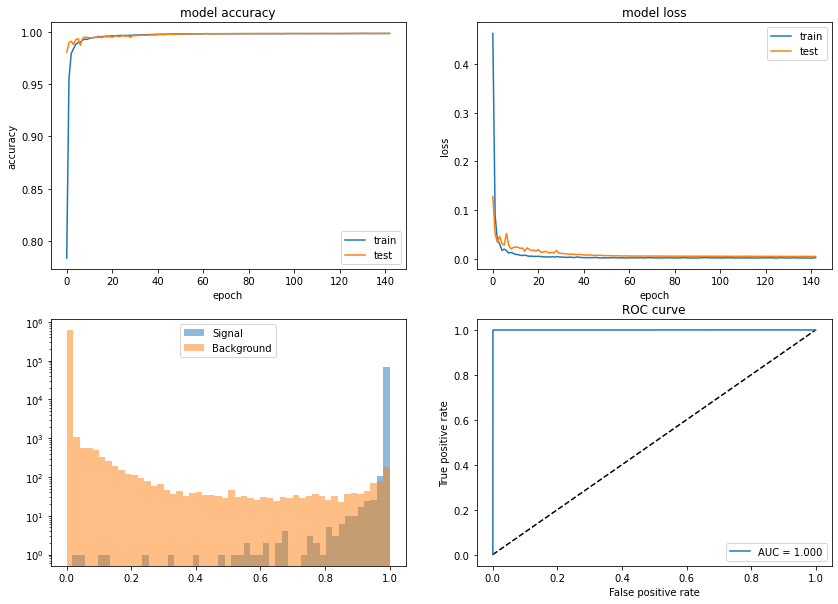

In [44]:
fig, axs = plt.subplots(2, 2,figsize=(14,10))
X_plotted = X_test
y_plotted = y_test

##### Plot accuracy
axs[0,0].plot(history.history['binary_accuracy'])
axs[0,0].plot(history.history['val_binary_accuracy'])
axs[0,0].set_title('model accuracy')
axs[0,0].set_ylabel('accuracy')
axs[0,0].set_xlabel('epoch')
axs[0,0].legend(['train', 'test'], loc='lower right')

##### Plot loss
axs[0,1].plot(history.history['loss'])
axs[0,1].plot(history.history['val_loss'])
axs[0,1].set_title('model loss')
axs[0,1].set_ylabel('loss')
axs[0,1].set_xlabel('epoch')
axs[0,1].legend(['train', 'test'], loc='upper right')

#### Plot predictions
pred_label_sig = ClassifierModel.predict(X_plotted[y_plotted==1])
pred_label_bkg = ClassifierModel.predict(X_plotted[y_plotted==0])

axs[1,0].hist(pred_label_sig, bins=50, alpha=0.5)
axs[1,0].hist(pred_label_bkg, bins=50, alpha=0.5)
axs[1,0].set_yscale('log')
axs[1,0].set_yscale('log')
axs[1,0].legend(['Signal', 'Background'], loc='upper center')

#### Draw ROC curve
pred_label = ClassifierModel.predict(X_plotted)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_plotted,pred_label)
AUC = auc(fpr_keras, tpr_keras)

axs[1,1].plot([0, 1], [0, 1], 'k--')
axs[1,1].plot(fpr_keras, tpr_keras, label='AUC = {:.3f}'.format(AUC))
axs[1,1].set_xlabel('False positive rate')
axs[1,1].set_ylabel('True positive rate')
axs[1,1].set_title('ROC curve')
axs[1,1].legend(loc='best')

plt.show()

### Check the correlation to mass

In [45]:
### Pearson's correlation
print("pearson  : ", np.corrcoef(pred_label_bkg.flatten(),m_test[y_test==0])[0][1])
print("spearman : ", stats.spearmanr(pred_label_bkg.flatten(),m_test[y_test==0])[0])

pearson  :  -0.03592584270794217
spearman :  -0.3876425383207849




## Adversary training


### Adversary parameters

In [46]:
adv_nLayers = 5
adv_nodePerLayer = 64
adv_activation = 'sigmoid'#'tanh'

reduce_lr = ReduceLROnPlateau(monitor=esMonitor, factor=0.95, verbose=1,
                              patience=10, min_lr=1.0e-4)
es = EarlyStopping(monitor=esMonitor, patience=esPatience, verbose=0, mode='auto')

print(m_test)
m_test_cat = tf.keras.utils.to_categorical(m_test, num_classes=20)
m_train_cat = tf.keras.utils.to_categorical(m_train, num_classes=20)

y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=2)

[18 11 19 ... 14 15  0]


### Loss definition

The adversary is a multi-classifier, that takes as input the output layer of the classifier. As the classifier reads both signal and background events, so will the adversary. However, we do not want the adversary to see the signal events, as these are concentrated in a single mass bin, and including them would bias the performance. In order to mask these events, a custom loss function has to be defined. This function is effectively a simple rewrite of the categorical cross-entropy, with an added term "(1 - l_true)", that's equal to 0 for signal events

In [47]:
# categorical cross-entropy, masked signal entries
def make_loss_a(alam):
    def loss(y_true, y_pred): # original loss
        y_pred, l_true = y_pred[:, :-1], y_pred[:, -1]  # prediction and label -> to remove signal from loss
        l_true = K.reshape(l_true, (-1, 1))
        loss_sum = K.sum(alam * -(y_true * K.log(y_pred)) * (1 - l_true), axis=-1)
        #loss_sum = K.sum(alam * -(y_true * K.log(y_pred)), axis=-1)
        return K.mean(loss_sum)  # / K.sum(1 - l_true, axis=0)
    return loss

def make_loss_a2(alam): # same function, different input format (for "manual" adversary training)
    def loss(y_true, y_pred): # original loss
        l_true = y_pred[:, -1]  # prediction and label -> to remove signal from loss
        l_true = K.reshape(l_true, (-1, 1))
        #loss_sum = K.sum(alam * -(y_true * K.log(y_pred)) * (1 - l_true), axis=-1)
        loss_sum = K.sum(alam * -(y_true * K.log(y_pred)), axis=-1)
        return K.mean(loss_sum)  # / K.sum(1 - l_true, axis=0)
    return loss

def make_loss_R(alam):
    def loss(y_true, y_pred):
        return alam * K.categorical_crossentropy(y_true, y_pred)
    return loss

### Adversary definition

In [48]:

Adversary = ClassifierModel(inputs)
Adversary = Dense(32, activation=adv_activation, kernel_initializer='normal')(Adversary)
#Adversary = Dropout(0.2)(Adversary)
Adversary = Dense(64, activation=adv_activation, kernel_initializer='normal')(Adversary)
Adversary = Dropout(0.2)(Adversary)
Adversary = Dense(128, activation=adv_activation, kernel_initializer='normal')(Adversary)
Adversary = Dropout(0.2)(Adversary)
Adversary = Dense(128, activation=adv_activation, kernel_initializer='normal')(Adversary)
#Adversary = Dropout(0.2)(Adversary)
#Adversary = Dense(128, activation=adv_activation, kernel_initializer='normal')(Adversary)
#Adversary = Dropout(0.2)(Adversary)
Adversary = Dense(20, activation='softmax', kernel_initializer='normal')(Adversary)    

LabelWeights = Input(shape=(1,))
AdversaryC = concatenate([Adversary, LabelWeights], axis=1)
AdversaryModel = Model(inputs=[inputs, LabelWeights], outputs = AdversaryC, name='Adversary')
#AdversaryModel = Model(inputs=inputs, outputs = Adversary, name='Adversary')

## Prevent Classifier for retraining
ClassifierModel.trainable = False

AdversaryModel.compile(loss=make_loss_a(1.0),
                       optimizer=Adam(clipnorm=1, lr=0.05),
                       metrics=['accuracy'],
                      )

AdversaryModel.summary()

Model: "Adversary"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
Classifier (Functional)         (None, 1)            13697       input_4[0][0]                    
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 32)           64          Classifier[0][0]                 
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 64)           2112        dense_21[0][0]                   
__________________________________________________________________________________________

### Adversary training

In [49]:
history_adv = AdversaryModel.fit(x=[X_train[y_train==0],y_train[y_train==0]], y=m_train_cat[y_train==0],
                             validation_data=([X_test[y_test==0], y_test[y_test==0]], m_test_cat[y_test==0]),
                             shuffle=True,
                             epochs=500,
                             batch_size = 2048,
                             callbacks=[reduce_lr,es]
                            )

#history_adv = AdversaryModel.fit(x=X_train[y_train==0], y=m_train_cat[y_train==0],
#                             validation_data=(X_test[y_test==0], m_test_cat[y_test==0]),
#                             shuffle=True,
#                             epochs=500,
#                             batch_size = 2048,
#                             callbacks=[reduce_lr]
#                            )

Epoch 1/500
136/136 [==============================] - 2s 17ms/step - loss: 2.9991 - accuracy: 0.0709 - val_loss: 2.9719 - val_accuracy: 0.0703
Epoch 2/500
136/136 [==============================] - 2s 15ms/step - loss: 2.9716 - accuracy: 0.0713 - val_loss: 2.9721 - val_accuracy: 0.0728
Epoch 3/500
136/136 [==============================] - 2s 15ms/step - loss: 2.9716 - accuracy: 0.0717 - val_loss: 2.9722 - val_accuracy: 0.0703
Epoch 4/500
136/136 [==============================] - 2s 15ms/step - loss: 2.9716 - accuracy: 0.0717 - val_loss: 2.9726 - val_accuracy: 0.0728
Epoch 5/500
136/136 [==============================] - 2s 15ms/step - loss: 2.9718 - accuracy: 0.0722 - val_loss: 2.9728 - val_accuracy: 0.0728
Epoch 6/500
136/136 [==============================] - 2s 15ms/step - loss: 2.9719 - accuracy: 0.0720 - val_loss: 2.9729 - val_accuracy: 0.0728
Epoch 7/500
136/136 [==============================] - 2s 15ms/step - loss: 2.9717 - accuracy: 0.0717 - val_loss: 2.9721 - val_accuracy:

### Save base adversary

In [50]:
ModelName = 'base_aversary_m' + mass_point + '_10Fixedbins_sampleWeights_maxmass'

AdversaryModel.save(work_dir + 'models/base_adversary/' + ModelName + '.h5')
AdversaryModel.save_weights(work_dir + 'models/base_adversary/' + ModelName + '_weights.h5')

### Draw adversary predictions

/home/llr/cms/portales/miniconda3/envs/MLenv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/llr/cms/portales/miniconda3/envs/MLenv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/llr/cms/portales/miniconda3/envs/MLenv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

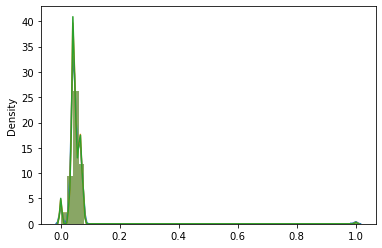

In [51]:
pred_label_0 = AdversaryModel.predict([X_test[m_test==0],y_test[m_test==0]])
pred_label_1 = AdversaryModel.predict([X_test[m_test==1],y_test[m_test==1]])
pred_label_2 = AdversaryModel.predict([X_test[m_test==2],y_test[m_test==2]])
#pred_label_3 = AdversaryModel.predict([X_test[m_test==3],y_test[m_test==3]])
#pred_label_4 = AdversaryModel.predict([X_test[m_test==4],y_test[m_test==4]])
#pred_label_5 = AdversaryModel.predict([X_test[m_test==5],y_test[m_test==5]])
#pred_label_6 = AdversaryModel.predict([X_test[m_test==6],y_test[m_test==6]])
#pred_label_7 = AdversaryModel.predict([X_test[m_test==7],y_test[m_test==7]])
#pred_label_8 = AdversaryModel.predict([X_test[m_test==8],y_test[m_test==8]])
#pred_label_9 = AdversaryModel.predict([X_test[m_test==9],y_test[m_test==9]])

#pred_label_0 = AdversaryModel.predict(X_test[m_test==0])
#pred_label_1 = AdversaryModel.predict(X_test[m_test==1])
#pred_label_2 = AdversaryModel.predict(X_test[m_test==2])

sns.distplot(pred_label_0)
sns.distplot(pred_label_1)
sns.distplot(pred_label_2)
#sns.distplot(pred_label_3)
#sns.distplot(pred_label_4)
#sns.distplot(pred_label_5)
#sns.distplot(pred_label_6)
#sns.distplot(pred_label_7)
#sns.distplot(pred_label_8)
#sns.distplot(pred_label_9)

plt.show()

### Draw accuracy and loss

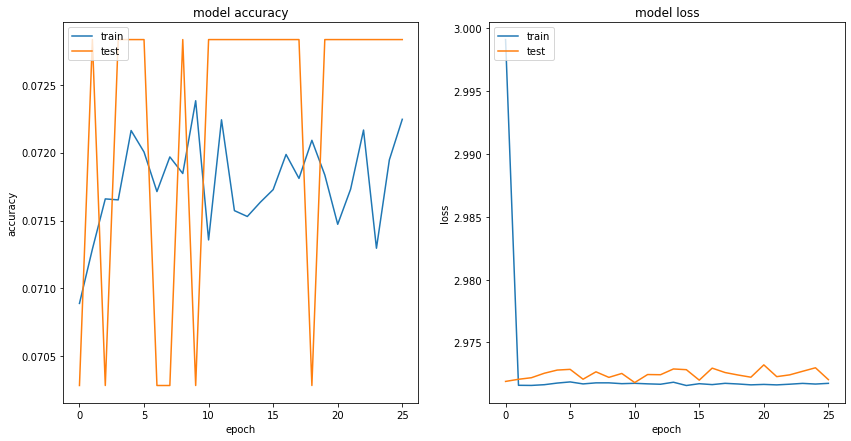

In [52]:
fig, axs = plt.subplots(1, 2,figsize=(14,7))


axs[0].plot(history_adv.history['accuracy'])
axs[0].plot(history_adv.history['val_accuracy'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'test'], loc='upper left')
    
    
axs[1].plot(history_adv.history['loss'])
axs[1].plot(history_adv.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'test'], loc='upper left')
    
plt.show()

## Load pre-trained classifier and adversary

In [53]:
#ModelName = '_benchmark_10bins'

# Classifier
ModelName = 'base_classifier_m' + mass_point + '_10Fixedbins_sampleWeights_maxmass'
ClassifierModel.load_weights(work_dir + 'models/base_classifier/' + ModelName + '_weights.h5')
ClassifierModel.summary()

# Adversary
ModelName = 'base_aversary_m' + mass_point + '_10Fixedbins_sampleWeights_maxmass'
AdversaryModel.load_weights(work_dir + 'models/base_adversary/' + ModelName + '_weights.h5')
AdversaryModel.summary()

# Metrics
#losses = pd.read_csv('/home/llr/cms/portales/test_fw/Scripts/models/combined_classifier_losses.csv', header=None, index_col=0).T.to_dict('list')
#Metrics = pd.read_csv('/home/llr/cms/portales/test_fw/Scripts/models/combined_classifier_metrics.csv', header=None, index_col=0).T.to_dict('list')

Model: "Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                1088      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0

### Define the combined model

**TODO**: 
- Optimize combination of LR and lbd values

In [54]:
CombinedModel = Model(inputs=[inputs, LabelWeights], outputs=[ClassifierModel(inputs), AdversaryModel([inputs, LabelWeights])], name="Combined")
#CombinedModel = Model(inputs=inputs, outputs=[ClassifierModel(inputs), AdversaryModel(inputs)], name="Combined")

lbd = 1.
CombinedLoss = make_loss_a(-lbd)
AdvLoss = make_loss_a(1.0)

losses = {"L_C": [], "L_A": [], "L_C - L_A": []}
Metrics = {"Acc_C": [], "Acc_A": [], "PearsonCorr": [], "SpearmanCorr":[], "KendallCorr":[]}

test_losses = {"L_C": [], "L_A": [], "L_C - L_A": []}
test_Metrics = {"Acc_C": [], "Acc_A": [], "PearsonCorr": [], "SpearmanCorr":[], "KendallCorr":[]}

batch_size = 10000#2048 #512
min_loss = np.inf
count = 0
mylr = 1e-5
ClassOpt = Adam(lr=mylr)
AdvOpt = Adam(lr=10 * mylr) 

CombinedModel.compile(loss=['binary_crossentropy', CombinedLoss], optimizer=ClassOpt, metrics=[['binary_accuracy'],['accuracy']])
CombinedModel.summary()

Model: "Combined"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
Classifier (Functional)         (None, 1)            13697       input_4[0][0]                    
__________________________________________________________________________________________________
Adversary (Functional)          (None, 21)           43285       input_4[0][0]                    
                                                                 input_5[0][0]             

### Combined training

**TODO**: 
- The sample_weight lines should be uncommented, but create format-related error

epoch 0/150
21794/21794 [==============================] - 16s 730us/step - loss: -2.6650 - Classifier_loss: 0.0109 - Adversary_loss: -2.6759 - Classifier_binary_accuracy: 0.9990 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0318), (Spearman: -0.4239), (Kendall: -0.2994)
                                         training metrics: loss: -1.4794 - Classifier_loss: 0.0012 - Adversary_loss: -1.4806 - Classifier_binary_accuracy: 0.9989 - Adversary_accuracy: 0.0351
Correlations (train): (Pearson: -0.0331), (Spearman: -0.418), (Kendall: -0.2950)


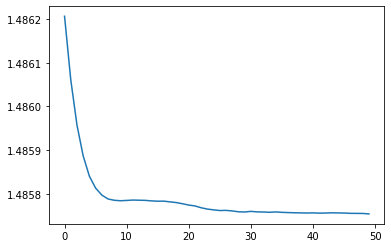

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 1/150
21794/21794 [==============================] - 17s 784us/step - loss: -2.6623 - Classifier_loss: 0.0128 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9988 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0315), (Spearman: -0.4163), (Kendall: -0.2936)
                                         training metrics: loss: -1.4914 - Classifier_loss: 0.0013 - Adversary_loss: -1.4927 - Classifier_binary_accuracy: 0.9987 - Adversary_accuracy: 0.0361
Correlations (train): (Pearson: -0.0296), (Spearman: -0.4142), (Kendall: -0.2922)


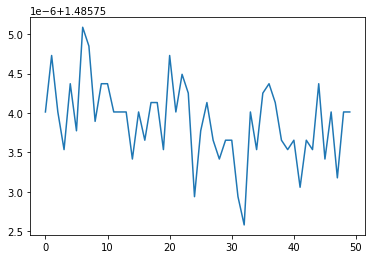

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 2/150
21794/21794 [==============================] - 16s 731us/step - loss: -2.6644 - Classifier_loss: 0.0106 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9991 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0284), (Spearman: -0.4123), (Kendall: -0.2907)
                                         training metrics: loss: -1.4791 - Classifier_loss: 0.0013 - Adversary_loss: -1.4805 - Classifier_binary_accuracy: 0.9987 - Adversary_accuracy: 0.035
Correlations (train): (Pearson: -0.0321), (Spearman: -0.4238), (Kendall: -0.2993)


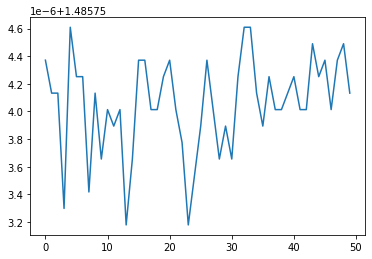

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 3/150
21794/21794 [==============================] - 17s 780us/step - loss: -2.6639 - Classifier_loss: 0.0112 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9990 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0309), (Spearman: -0.4218), (Kendall: -0.2977)
                                         training metrics: loss: -1.4858 - Classifier_loss: 0.0014 - Adversary_loss: -1.4872 - Classifier_binary_accuracy: 0.9987 - Adversary_accuracy: 0.0369
Correlations (train): (Pearson: -0.0285), (Spearman: -0.3954), (Kendall: -0.2779)


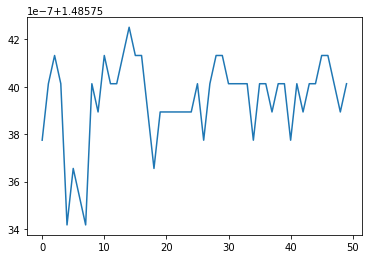

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 4/150
21794/21794 [==============================] - 16s 753us/step - loss: -2.6623 - Classifier_loss: 0.0128 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9991 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0274), (Spearman: -0.3935), (Kendall: -0.2764)
                                         training metrics: loss: -1.4934 - Classifier_loss: 0.0016 - Adversary_loss: -1.4951 - Classifier_binary_accuracy: 0.9990 - Adversary_accuracy: 0.0365
Correlations (train): (Pearson: -0.0266), (Spearman: -0.3858), (Kendall: -0.2708)


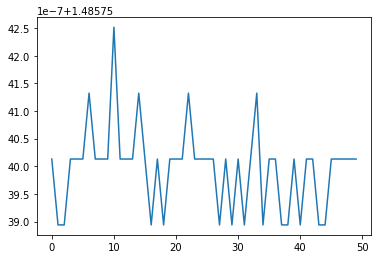

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 5/150
21794/21794 [==============================] - 16s 718us/step - loss: -2.6641 - Classifier_loss: 0.0110 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9991 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0258), (Spearman: -0.3837), (Kendall: -0.2691)
Lowering learning rate to 5.0e-04
                                         training metrics: loss: -1.4831 - Classifier_loss: 0.0028 - Adversary_loss: -1.486 - Classifier_binary_accuracy: 0.9990 - Adversary_accuracy: 0.0354
Correlations (train): (Pearson: -0.0247), (Spearman: -0.3898), (Kendall: -0.2738)


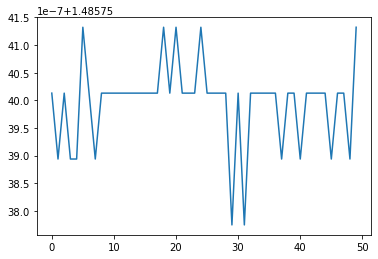

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 6/150
21794/21794 [==============================] - 16s 733us/step - loss: -2.6668 - Classifier_loss: 0.0082 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9993 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0242), (Spearman: -0.3878), (Kendall: -0.2722)
                                         training metrics: loss: -1.4838 - Classifier_loss: 0.001 - Adversary_loss: -1.4848 - Classifier_binary_accuracy: 0.9990 - Adversary_accuracy: 0.0367
Correlations (train): (Pearson: -0.0275), (Spearman: -0.3961), (Kendall: -0.2786)


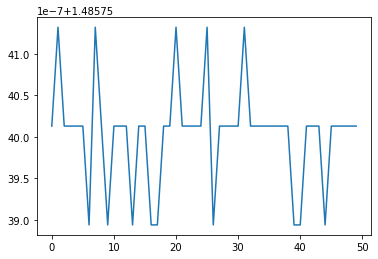

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 7/150
21794/21794 [==============================] - 17s 768us/step - loss: -2.6655 - Classifier_loss: 0.0096 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9991 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0268), (Spearman: -0.3942), (Kendall: -0.2770)
                                         training metrics: loss: -1.4777 - Classifier_loss: 0.0009 - Adversary_loss: -1.4786 - Classifier_binary_accuracy: 0.9989 - Adversary_accuracy: 0.0357
Correlations (train): (Pearson: -0.0293), (Spearman: -0.3937), (Kendall: -0.277)


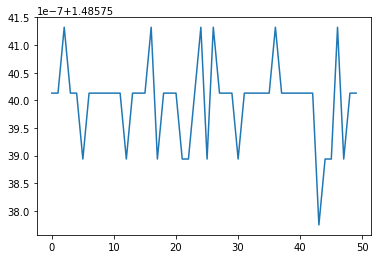

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 8/150
21794/21794 [==============================] - 16s 753us/step - loss: -2.6639 - Classifier_loss: 0.0111 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9990 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0278), (Spearman: -0.3916), (Kendall: -0.2753)
                                         training metrics: loss: -1.4926 - Classifier_loss: 0.0009 - Adversary_loss: -1.4935 - Classifier_binary_accuracy: 0.9991 - Adversary_accuracy: 0.0367
Correlations (train): (Pearson: -0.0265), (Spearman: -0.3865), (Kendall: -0.2716)


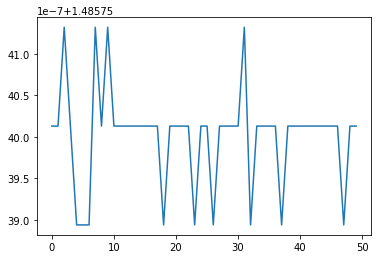

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 9/150
21794/21794 [==============================] - 16s 714us/step - loss: -2.6659 - Classifier_loss: 0.0092 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9992 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0251), (Spearman: -0.3842), (Kendall: -0.2698)
                                         training metrics: loss: -1.4891 - Classifier_loss: 0.0009 - Adversary_loss: -1.4901 - Classifier_binary_accuracy: 0.9990 - Adversary_accuracy: 0.0352
Correlations (train): (Pearson: -0.0277), (Spearman: -0.3759), (Kendall: -0.2637)


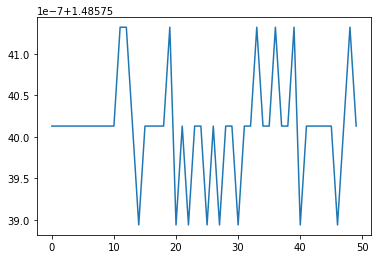

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 10/150
21794/21794 [==============================] - 17s 764us/step - loss: -2.6641 - Classifier_loss: 0.0109 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9991 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0261), (Spearman: -0.3737), (Kendall: -0.262)
                                         training metrics: loss: -1.4894 - Classifier_loss: 0.0014 - Adversary_loss: -1.4909 - Classifier_binary_accuracy: 0.9990 - Adversary_accuracy: 0.0357
Correlations (train): (Pearson: -0.0271), (Spearman: -0.3723), (Kendall: -0.2609)


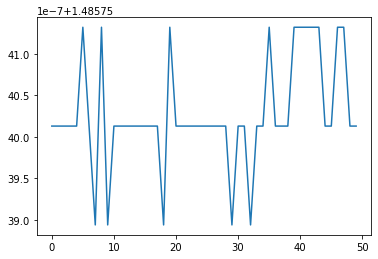

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 11/150
21794/21794 [==============================] - 17s 770us/step - loss: -2.6644 - Classifier_loss: 0.0107 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9992 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0257), (Spearman: -0.3700), (Kendall: -0.2591)
Lowering learning rate to 2.5e-04
                                         training metrics: loss: -1.4833 - Classifier_loss: 0.001 - Adversary_loss: -1.4843 - Classifier_binary_accuracy: 0.9991 - Adversary_accuracy: 0.0344
Correlations (train): (Pearson: -0.0264), (Spearman: -0.3801), (Kendall: -0.2667)


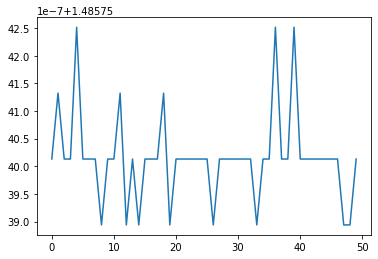

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 12/150
21794/21794 [==============================] - 17s 795us/step - loss: -2.6649 - Classifier_loss: 0.0102 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9992 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0253), (Spearman: -0.3779), (Kendall: -0.2649)
                                         training metrics: loss: -1.4942 - Classifier_loss: 0.0009 - Adversary_loss: -1.4952 - Classifier_binary_accuracy: 0.9992 - Adversary_accuracy: 0.037
Correlations (train): (Pearson: -0.0266), (Spearman: -0.3825), (Kendall: -0.2685)


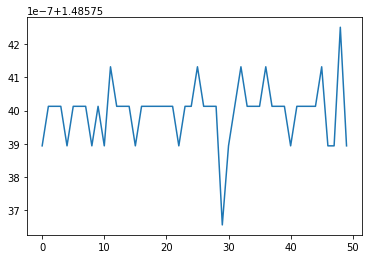

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 13/150
21794/21794 [==============================] - 18s 824us/step - loss: -2.6642 - Classifier_loss: 0.0109 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9992 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0255), (Spearman: -0.3803), (Kendall: -0.2667)
                                         training metrics: loss: -1.4785 - Classifier_loss: 0.0010 - Adversary_loss: -1.4795 - Classifier_binary_accuracy: 0.9992 - Adversary_accuracy: 0.0351
Correlations (train): (Pearson: -0.0253), (Spearman: -0.3924), (Kendall: -0.2757)


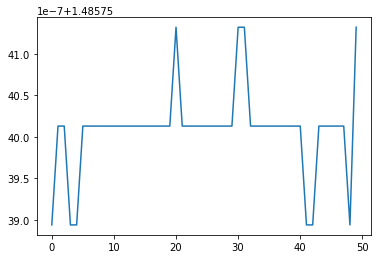

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 14/150
21794/21794 [==============================] - 18s 827us/step - loss: -2.6665 - Classifier_loss: 0.0086 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9993 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0243), (Spearman: -0.3902), (Kendall: -0.2739)
                                         training metrics: loss: -1.4837 - Classifier_loss: 0.0008 - Adversary_loss: -1.4845 - Classifier_binary_accuracy: 0.9991 - Adversary_accuracy: 0.0365
Correlations (train): (Pearson: -0.0264), (Spearman: -0.3968), (Kendall: -0.2791)


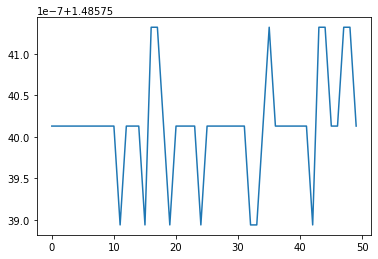

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 15/150
21794/21794 [==============================] - 17s 789us/step - loss: -2.6659 - Classifier_loss: 0.0092 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9992 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0256), (Spearman: -0.3946), (Kendall: -0.2773)
                                         training metrics: loss: -1.4744 - Classifier_loss: 0.0010 - Adversary_loss: -1.4754 - Classifier_binary_accuracy: 0.9992 - Adversary_accuracy: 0.0362
Correlations (train): (Pearson: -0.0271), (Spearman: -0.3994), (Kendall: -0.2809)


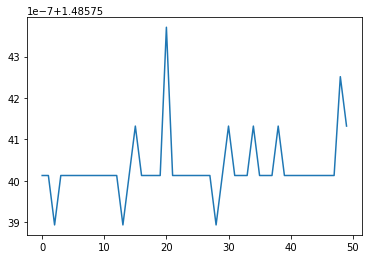

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 16/150
21794/21794 [==============================] - 17s 779us/step - loss: -2.6655 - Classifier_loss: 0.0095 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9992 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0264), (Spearman: -0.3972), (Kendall: -0.2791)
Lowering learning rate to 1.3e-04
                                         training metrics: loss: -1.4889 - Classifier_loss: 0.0009 - Adversary_loss: -1.4899 - Classifier_binary_accuracy: 0.9992 - Adversary_accuracy: 0.0368
Correlations (train): (Pearson: -0.0272), (Spearman: -0.4012), (Kendall: -0.2823)


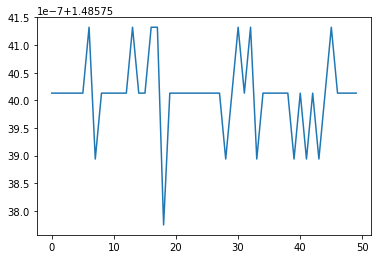

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 17/150
21794/21794 [==============================] - 17s 773us/step - loss: -2.6659 - Classifier_loss: 0.0092 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9992 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0265), (Spearman: -0.3990), (Kendall: -0.2805)
                                         training metrics: loss: -1.4864 - Classifier_loss: 0.001 - Adversary_loss: -1.4873 - Classifier_binary_accuracy: 0.9990 - Adversary_accuracy: 0.0359
Correlations (train): (Pearson: -0.0275), (Spearman: -0.3987), (Kendall: -0.2804)


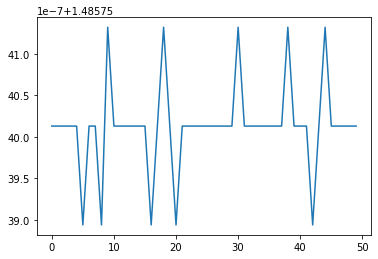

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 18/150
21794/21794 [==============================] - 18s 807us/step - loss: -2.6655 - Classifier_loss: 0.0096 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9992 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0268), (Spearman: -0.3965), (Kendall: -0.2786)
                                         training metrics: loss: -1.4887 - Classifier_loss: 0.001 - Adversary_loss: -1.4897 - Classifier_binary_accuracy: 0.9992 - Adversary_accuracy: 0.0365
Correlations (train): (Pearson: -0.0269), (Spearman: -0.3991), (Kendall: -0.2807)


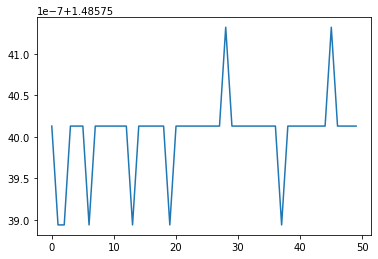

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 19/150
21794/21794 [==============================] - 17s 796us/step - loss: -2.6662 - Classifier_loss: 0.0089 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9993 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0261), (Spearman: -0.3969), (Kendall: -0.2789)
                                         training metrics: loss: -1.4804 - Classifier_loss: 0.0009 - Adversary_loss: -1.4813 - Classifier_binary_accuracy: 0.9993 - Adversary_accuracy: 0.0352
Correlations (train): (Pearson: -0.027), (Spearman: -0.3984), (Kendall: -0.2802)


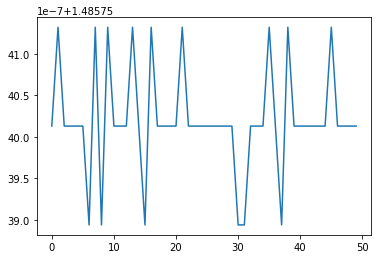

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 20/150
21794/21794 [==============================] - 15s 702us/step - loss: -2.6662 - Classifier_loss: 0.0088 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9993 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0261), (Spearman: -0.3962), (Kendall: -0.2784)
Lowering learning rate to 6.3e-05
                                         training metrics: loss: -1.4948 - Classifier_loss: 0.002 - Adversary_loss: -1.4968 - Classifier_binary_accuracy: 0.9989 - Adversary_accuracy: 0.0356
Correlations (train): (Pearson: -0.0273), (Spearman: -0.3942), (Kendall: -0.2770)


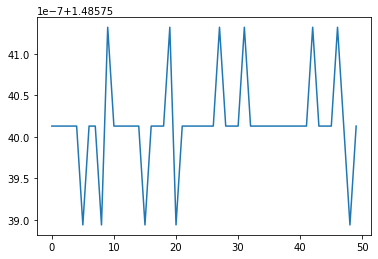

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 21/150
21794/21794 [==============================] - 14s 639us/step - loss: -2.6654 - Classifier_loss: 0.0097 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9992 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0265), (Spearman: -0.392), (Kendall: -0.2752)
Lowering learning rate to 3.1e-05
                                         training metrics: loss: -1.4916 - Classifier_loss: 0.0009 - Adversary_loss: -1.4925 - Classifier_binary_accuracy: 0.9994 - Adversary_accuracy: 0.0359
Correlations (train): (Pearson: -0.0273), (Spearman: -0.3939), (Kendall: -0.2768)


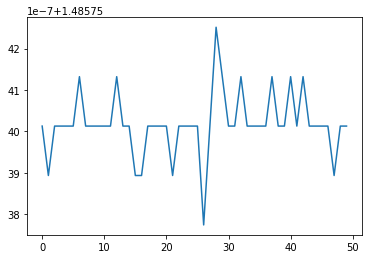

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 22/150
21794/21794 [==============================] - 19s 890us/step - loss: -2.6655 - Classifier_loss: 0.0095 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9992 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0264), (Spearman: -0.3917), (Kendall: -0.2750)
                                         training metrics: loss: -1.4742 - Classifier_loss: 0.0019 - Adversary_loss: -1.4761 - Classifier_binary_accuracy: 0.9993 - Adversary_accuracy: 0.0374
Correlations (train): (Pearson: -0.0269), (Spearman: -0.3947), (Kendall: -0.2775)


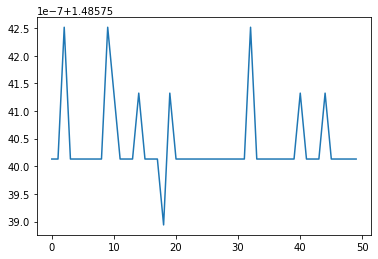

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 23/150
21794/21794 [==============================] - 16s 747us/step - loss: -2.6659 - Classifier_loss: 0.0092 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9993 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.026), (Spearman: -0.3925), (Kendall: -0.2757)
                                         training metrics: loss: -1.4884 - Classifier_loss: 0.0011 - Adversary_loss: -1.4895 - Classifier_binary_accuracy: 0.9991 - Adversary_accuracy: 0.0366
Correlations (train): (Pearson: -0.0266), (Spearman: -0.3958), (Kendall: -0.2782)


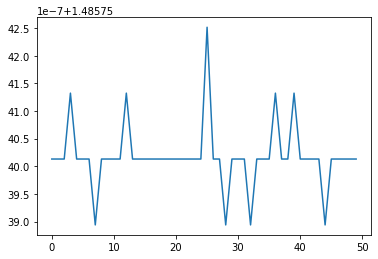

_______________________________________________________________________________________________________________________________________________________________________________________________
epoch 24/150
21794/21794 [==============================] - 16s 724us/step - loss: -2.6663 - Classifier_loss: 0.0088 - Adversary_loss: -2.6751 - Classifier_binary_accuracy: 0.9993 - Adversary_accuracy: 0.0656
Correlations (test): (Pearson: -0.0257), (Spearman: -0.3936), (Kendall: -0.2764)
                                         training metrics: loss: -1.4840 - Classifier_loss: 0.0009 - Adversary_loss: -1.485 - Classifier_binary_accuracy: 0.9994 - Adversary_accuracy: 0.0370
Correlations (train): (Pearson: -0.0266), (Spearman: -0.3961), (Kendall: -0.2785)


In [ ]:
n_epochs_comb = 150
n_epochs_clas = 10
n_epochs_adv = 50

mylr = 1e-3

ClassOpt = Adam(lr=mylr)
AdvOpt = Adam(lr=10 * mylr) #Adam(lr=10 * mylr)

for epoch in range(n_epochs_comb):
    print("epoch {0}/{1}".format(epoch,n_epochs_comb))
    
    # Store original losses
    m_losses = CombinedModel.evaluate([X_test, y_test], 
#    m_losses = CombinedModel.evaluate({X_test, 
                                      [y_test,m_test_cat],
                                      sample_weight=[sampleWeights_test, np.ones_like(y_test)],
                                      verbose=1
                                      )
    
    # Retrieve correlation coefficients
    pred_label_comb_0 = ClassifierModel.predict(X_test[y_test==0])    
    coef = np.corrcoef(pred_label_comb_0.flatten(),m_test[y_test==0])
    spcoef, pval = stats.spearmanr(pred_label_comb_0.flatten(),m_test[y_test==0])
    kcoef, pval = stats.kendalltau(pred_label_comb_0.flatten(),m_test[y_test==0])
    print('Correlations (test): (Pearson: {0}), (Spearman: {1}), (Kendall: {2})'.format(np.format_float_positional(coef[0][1], precision=4), np.format_float_positional(spcoef, precision=4), np.format_float_positional(kcoef, precision=4)))    
    
    # Store all metrics
    test_losses["L_C - L_A"].append(m_losses[0])
    test_losses["L_C"].append(m_losses[1])
    test_losses["L_A"].append(m_losses[2])

    test_Metrics["Acc_C"].append(m_losses[3])
    test_Metrics["Acc_A"].append(m_losses[4])
    test_Metrics["PearsonCorr"].append(coef[0][1])
    test_Metrics["SpearmanCorr"].append(spcoef)
    test_Metrics["KendallCorr"].append(kcoef)
    
    # Adapt LR if needed
    current_loss = m_losses[0]
    if current_loss < min_loss:
        min_loss = current_loss
        count = 0
    else:
        count += 1
    if (count > 0 and count % 5 == 0) or (epoch%20==0 and epoch > 0):
        mylr = mylr * np.sqrt(0.25)
        ClassOpt = Adam(lr=mylr)
        print('Lowering learning rate to {0:1.01e}'.format(mylr))
    
    
    # Fit classifier
    indices = np.random.permutation(len(X_train))
    AdversaryModel.trainable = False
    ClassifierModel.trainable = True
    
    CombinedModel.compile(loss=['binary_crossentropy', CombinedLoss], optimizer=ClassOpt, metrics=[['binary_accuracy'],['accuracy']])
    
    for epoch_clas in range(n_epochs_clas):
        indices = np.random.permutation(len(X_train))[:50000]
        m_losses_train = CombinedModel.train_on_batch(x=[X_train[indices], y_train[indices]],
                                     y=[y_train[indices], m_train_cat[indices]],
                                     #sample_weight=[Weights, dummyWeights]
                                     sample_weight=[sampleWeights[indices], np.ones_like(y_train[indices])]
                                    )
    print("                                         training metrics: loss: {0} - Classifier_loss: {1} - Adversary_loss: {2} - Classifier_binary_accuracy: {3} - Adversary_accuracy: {4}".format(np.format_float_positional(m_losses_train[0], precision=4),
                                                                                                                                                                                                 np.format_float_positional(m_losses_train[1], precision=4),
                                                                                                                                                                                                 np.format_float_positional(m_losses_train[2], precision=4),
                                                                                                                                                                                                 np.format_float_positional(m_losses_train[3], precision=4),
                                                                                                                                                                                                 np.format_float_positional(m_losses_train[4], precision=4)))
    losses["L_C - L_A"].append(m_losses_train[0])
    losses["L_C"].append(m_losses_train[1])
    losses["L_A"].append(m_losses_train[0]-m_losses_train[1])

    Metrics["Acc_C"].append(m_losses_train[3])
    Metrics["Acc_A"].append(m_losses_train[4])
    
    pred_label_comb_0 = ClassifierModel.predict(X_train[y_train==0])    
    coef = np.corrcoef(pred_label_comb_0.flatten(),m_train[y_train==0])
    spcoef, pval = stats.spearmanr(pred_label_comb_0.flatten(),m_train[y_train==0])
    kcoef, pval = stats.kendalltau(pred_label_comb_0.flatten(),m_train[y_train==0])
    Metrics["PearsonCorr"].append(coef[0][1])
    Metrics["SpearmanCorr"].append(spcoef)
    Metrics["KendallCorr"].append(kcoef)
    print('Correlations (train): (Pearson: {0}), (Spearman: {1}), (Kendall: {2})'.format(np.format_float_positional(coef[0][1], precision=4), np.format_float_positional(spcoef, precision=4), np.format_float_positional(kcoef, precision=4))) 
    
    # Fit adversary
    AdversaryModel.trainable = True
    ClassifierModel.trainable = False
    
    AdversaryModel.compile(loss=AdvLoss, optimizer=AdvOpt)
    tmp_history = []
    for epoch_adv in range(n_epochs_adv):
        indices = np.random.permutation(len(X_train))
        tmp_history.append(AdversaryModel.train_on_batch(x=[X_train[indices], y_train[indices]],
                                                         y=m_train_cat[indices],))
    
    plt.plot(tmp_history)
    plt.show()
    # Save the networks once every while
    if epoch%10==0 and epoch > 0:
        ModelName = 'combined_m' + mass_point + '_10bins_{0}epochs'.format(epoch)

        ClassifierModel.save(work_dir + 'models/combined_classifier/tmp/classifier_' + ModelName + '.h5')
        ClassifierModel.save_weights(work_dir + 'models/combined_classifier/tmp/classifier_' + ModelName + '_weights.h5')

        AdversaryModel.save(work_dir + 'models/combined_classifier/tmp/adversary_' + ModelName + '.h5')
        AdversaryModel.save_weights(work_dir + 'models/combined_classifier/tmp/adversary_' + ModelName + '_weights.h5')

    print('_______________________________________________________________________________________________________________________________________________________________________________________________')
    
print('All epochs finished')

### Plot sanity checks

**TODO**: 
- Multiclass ROC for adversary
- ROC curve comparisons between base NN and combined NN (1/eff_bkg format for clarity)

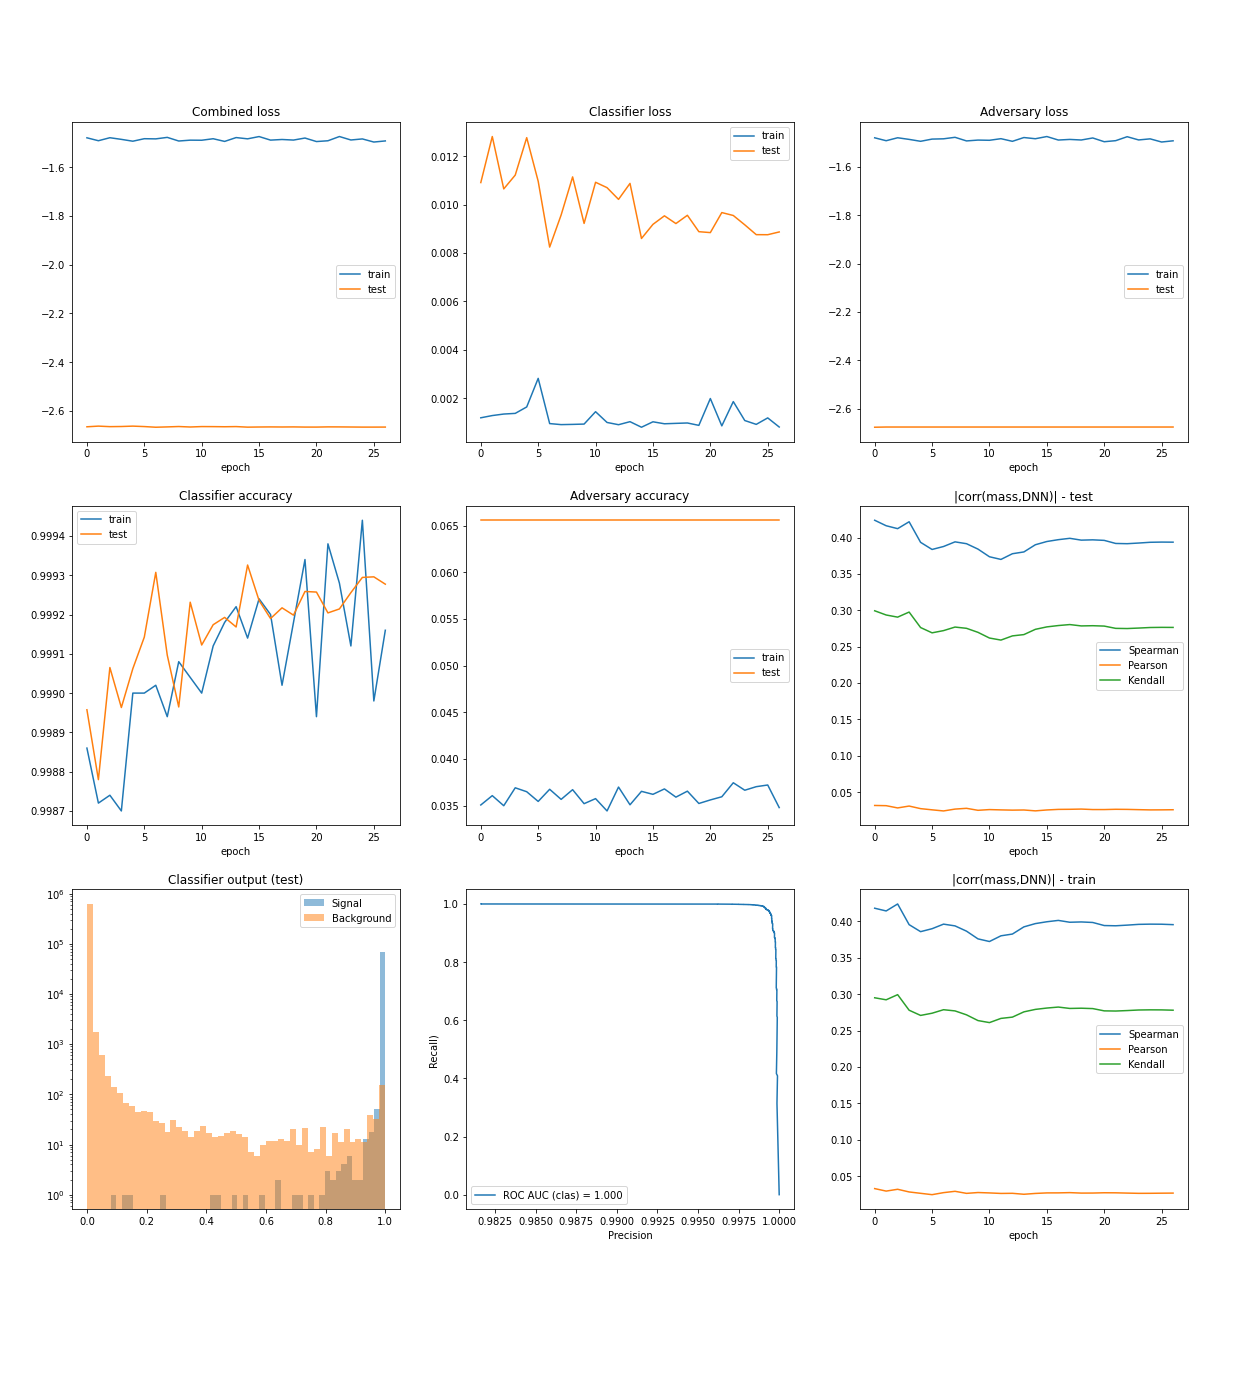

In [461]:
fig, axs = plt.subplots(3, 3,figsize=(20,20))

from matplotlib.patches import Rectangle
rect = Rectangle((0.08, 0.01), 0.85, 0.95, facecolor='white', edgecolor='none',
                 transform=fig.transFigure, zorder=-1)
fig.patches.append(rect)

pred_label_comb_0 = ClassifierModel.predict(X_test[y_test==0])
pred_label_comb_1 = ClassifierModel.predict(X_test[y_test==1])

def norm(data):
#    return (data)/np.abs((np.float64(data[0])))
#    return (data)/(np.float64(data[0]))
    return data

##### Plot accuracies
axs[1,0].plot(norm(Metrics["Acc_C"]))
axs[1,0].plot(norm(test_Metrics["Acc_C"]))
axs[1,0].set_title('Classifier accuracy')
axs[1,0].set_xlabel('epoch')
axs[1,0].legend(['train', 'test'], loc='best')

axs[1,1].plot(norm(Metrics["Acc_A"]))
axs[1,1].plot(norm(test_Metrics["Acc_A"]))
axs[1,1].set_title('Adversary accuracy')
axs[1,1].set_xlabel('epoch')
axs[1,1].legend(['train', 'test'], loc='best')


##### Plot correlation
axs[1,2].plot(np.abs(test_Metrics["SpearmanCorr"]))
axs[1,2].plot(np.abs(test_Metrics["PearsonCorr"]))
axs[1,2].plot(np.abs(test_Metrics["KendallCorr"]))
axs[1,2].set_title('|corr(mass,DNN)| - test')
axs[1,2].set_xlabel('epoch')
axs[1,2].legend(["Spearman", "Pearson", "Kendall"], loc='best')

axs[2,2].plot(np.abs(Metrics["SpearmanCorr"]))
axs[2,2].plot(np.abs(Metrics["PearsonCorr"]))
axs[2,2].plot(np.abs(Metrics["KendallCorr"]))
axs[2,2].set_title('|corr(mass,DNN)| - train')
axs[2,2].set_xlabel('epoch')
axs[2,2].legend(["Spearman", "Pearson", "Kendall"], loc='best')


##### Plot losses
axs[0,0].plot(norm(losses["L_C - L_A"]))
axs[0,0].plot(norm(test_losses["L_C - L_A"]))
axs[0,0].set_title('Combined loss')
axs[0,0].set_xlabel('epoch')
axs[0,0].legend(["train", "test"], loc='best')

axs[0,1].plot(norm(losses["L_C"]))
axs[0,1].plot(norm(test_losses["L_C"]))
axs[0,1].set_title('Classifier loss')
axs[0,1].set_xlabel('epoch')
axs[0,1].legend(["train", "test"], loc='best')

axs[0,2].plot(norm(losses["L_A"]))
axs[0,2].plot(norm(test_losses["L_A"]))
axs[0,2].set_title('Adversary loss')
axs[0,2].set_xlabel('epoch')
axs[0,2].legend(["train", "test"], loc='best')


#### Plot predictions
axs[2,0].hist(pred_label_comb_1, bins=50, alpha=0.5)
axs[2,0].hist(pred_label_comb_0, bins=50, alpha=0.5)
axs[2,0].set_yscale('log')
axs[2,0].set_title('Classifier output (test)')
#axs[2,0].set_ylim(10e-5,1000)
axs[2,0].legend(['Signal', 'Background'], loc='best')


#### Draw ROC curve
pred_label_tot = ClassifierModel.predict(X_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test,pred_label_tot)
AUC = auc(fpr_keras, tpr_keras)


# calculate precision-recall curve
precision, recall, thrsh = precision_recall_curve(y_test, pred_label_tot)
axs[2,1].plot(precision, recall, label='ROC AUC (clas) = {:.3f}'.format(AUC))
axs[2,1].set_xlabel('Precision')
axs[2,1].set_ylabel('Recall)')
axs[2,1].legend(loc='best')

plt.show()

#### Save fully trained networks 

In [462]:
ModelName = 'combined_m' + mass_point + '_10Fixedbins_sampleWeights_maxmass_24epochs'
#ModelName = 'combined_m' + mass_point + '_10Fixedbins_sampleWeights'

ClassifierModel.save(work_dir + 'models/combined_classifier/classifier_'+ModelName+'.h5')
ClassifierModel.save_weights(work_dir + 'models/combined_classifier/classifier_'+ModelName+'_weights.h5')

AdversaryModel.save(work_dir + 'models/combined_classifier/adversary_'+ModelName+'.h5')
AdversaryModel.save_weights(work_dir + 'models/combined_classifier/adversary_'+ModelName+'_weights.h5')

### save metrics to csv

In [463]:
import csv

name = '10Fixedbins_sampleWeights_maxmass_24epochs'

with open(work_dir + 'metrics/combined_classifier_m' + mass_point + '_' + name + '_train_losses.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in losses.items():
       writer.writerow([key, value])

with open(work_dir + 'metrics/combined_classifier_m' + mass_point + '_'+ name + '_train_metrics.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in Metrics.items():
       writer.writerow([key, value])
    
with open(work_dir + 'metrics/combined_classifier_m' + mass_point + '_' + name + '_test_losses.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in test_losses.items():
       writer.writerow([key, value])
 
with open(work_dir + 'metrics/combined_classifier_m' + mass_point + '_' + name + '_test_metrics.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in test_Metrics.items():
       writer.writerow([key, value])

## Mass sculpting check

### Reload classifiers

In [20]:

inputs = Input(shape=(X_train.shape[1], ))
ClassifierBase = Dense(cla_nodePerLayer, activation=cla_activation)(inputs)
ClassifierBase = Dropout(cla_dropout)(ClassifierBase)
for i in range(cla_nLayers-1):   
    ClassifierBase = Dense(cla_nodePerLayer+ (cla_nodePerLayer)*(i<cla_nLayers and i>0), activation=cla_activation)(ClassifierBase)
    ClassifierBase = Dropout(cla_dropout)(ClassifierBase)
ClassifierBase = Dense(1, activation='sigmoid')(ClassifierBase)

### Base classifier
ClassifierModelBase = Model(inputs=inputs, outputs=ClassifierBase, name='ClassifierBase')
ClassifierModelBase.compile(optimizer=Adam(lr=10e-4), loss=loss_base, metrics=['binary_accuracy'])
ModelName = 'base_classifier_m' + mass_point + '_10Fixedbins_sampleWeights_maxmass'
ClassifierModelBase.load_weights(work_dir + 'models/base_classifier/' + ModelName + '_weights.h5')
ClassifierModelBase.summary()

#inputs = Input(shape=(X_train.shape[1], ))
Classifier = Dense(cla_nodePerLayer, activation=cla_activation)(inputs)
Classifier = Dropout(cla_dropout)(Classifier)
for i in range(cla_nLayers-1):   
    Classifier = Dense(cla_nodePerLayer+ (cla_nodePerLayer)*(i<cla_nLayers and i>0), activation=cla_activation)(Classifier)
    Classifier = Dropout(cla_dropout)(Classifier)
Classifier = Dense(1, activation='sigmoid')(Classifier)
### DANN
ClassifierModel = Model(inputs=inputs, outputs=Classifier, name='Classifier')
ClassifierModel.compile(optimizer=Adam(lr=10e-4), loss=loss_base, metrics=['binary_accuracy'])
ModelName = 'combined_m' + mass_point + '_10Fixedbins_sampleWeights_maxmass_24epochs'
ClassifierModel.load_weights(work_dir + 'models/combined_classifier/classifier_'+ModelName+'_weights.h5')
ClassifierModel.summary()


Model: "ClassifierBase"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                1088      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)            

### Retrieve unprocessessed data

Data previously loaded passed through MinMax scaler. Here we want to have a look at the actual invariant mass distribution 

In [22]:
X_train_bkg_noproc, y_train_bkg_noproc, m_train_bkg_noproc, X_test_bkg_noproc, y_test_bkg_noproc, m_test_bkg_noproc, var_name_bkg_noproc = load_data(bkg_in, allBranches, inFeatures, isSig = False , preproc = False)
df = pd.DataFrame(X_test_bkg_noproc, columns=var_name_bkg_noproc)

# Add the NNs predictions to the dataframe
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train_bkg_noproc)
df.insert(0,'DANN', ClassifierModel.predict(scaler.transform(X_test_bkg_noproc)) , True)
pred_label_base = ClassifierModelBase.predict(scaler.transform(X_test_bkg_noproc))
df.insert(0,'DNNbase', pred_label_base , True)

[ 237.52062744  301.17974634  364.83886523  428.49798413  492.15710303
  555.81622192  619.47534082  683.13445972  746.79357861  810.45269751
  874.11181641  937.7709353  1001.4300542  1065.0891731  1128.74829199
 1192.40741089 1256.06652979 1319.72564868 1383.38476758 1447.04388647
 1510.70300537]
[ 237.52062744  301.17974634  364.83886523  428.49798413  492.15710303
  555.81622192  619.47534082  683.13445972  746.79357861  810.45269751
  874.11181641  937.7709353  1001.4300542  1065.0891731  1128.74829199
 1192.40741089 1256.06652979 1319.72564868 1383.38476758 1447.04388647
 1510.70300537]
[272.01215 602.5987  429.66315 ... 363.04333 376.07047 295.79852]
[ 125.18100586  126.68036684  128.17972782  129.67908881  131.17844979
  132.67781077  134.17717175  135.67653273  137.17589372  138.6752547
  140.17461568  141.67397666  143.17333764  144.67269863  146.17205961
  147.67142059  149.17078157  150.67014255  152.16950354  153.66886452
  155.1682255   156.66758648  158.16694747  159.666

(3139100,)
(2511280, 16) (2511280,)


ValueError: too many values to unpack (expected 7)

### Plot the mass with various cuts on NNs

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(20,9))

axs[0].hist(df.HHKin_mass_raw[df.DANN>0.]     , alpha=1, density=False, bins=range(200,1500,int(1300/20)))
axs[0].hist(df.HHKin_mass_raw[df.DANN>0.001]  , alpha=1, density=False, bins=range(200,1500,int(1300/20)))
axs[0].hist(df.HHKin_mass_raw[df.DANN>0.01]   , alpha=1, density=False, bins=range(200,1500,int(1300/20)))
axs[0].hist(df.HHKin_mass_raw[df.DANN>0.1]    , alpha=1, density=False, bins=range(200,1500,int(1300/20)))
axs[0].hist(df.HHKin_mass_raw[df.DANN>0.6]    , alpha=1, density=False, bins=range(200,1500,int(1300/20)))
axs[0].set_yscale('log')
axs[0].legend(['DANN>=0.0', 'DANN>0.001', 'DNN>0.01', 'DANN>0.1', 'DANN>0.6', 'DANN>0.9'], loc='best')


axs[1].hist(df.HHKin_mass_raw[df.DNNbase>-0.1]   , alpha=1, density=False, bins=range(200,1500,int(1300/20)))
axs[1].hist(df.HHKin_mass_raw[df.DNNbase>0.001]  , alpha=1, density=False, bins=range(200,1500,int(1300/20)))
axs[1].hist(df.HHKin_mass_raw[df.DNNbase>0.01]   , alpha=1, density=False, bins=range(200,1500,int(1300/20)))
axs[1].hist(df.HHKin_mass_raw[df.DNNbase>0.1]    , alpha=1, density=False, bins=range(200,1500,int(1300/20)))
axs[1].hist(df.HHKin_mass_raw[df.DNNbase>0.995]  , alpha=1, density=False, bins=range(200,1500,int(1300/20)))
axs[1].set_yscale('log')
axs[1].legend(['DNN>=0.0', 'DNN>0.001', 'DNN>0.01', 'DNN>0.1', 'DNN>0.6', 'DNN>0.995'], loc='best')

plt.show()

### Retrieve predictions for background

[ 238.01052307  299.49545023  360.98037738  422.46530453  483.95023169
  545.43515884  606.920086    668.40501315  729.88994031  791.37486746
  852.85979462  914.34472177  975.82964893 1037.31457608 1098.79950323
 1160.28443039 1221.76935754 1283.2542847  1344.73921185 1406.22413901
 1467.70906616]
[ 238.01052307  299.49545023  360.98037738  422.46530453  483.95023169
  545.43515884  606.920086    668.40501315  729.88994031  791.37486746
  852.85979462  914.34472177  975.82964893 1037.31457608 1098.79950323
 1160.28443039 1221.76935754 1283.2542847  1344.73921185 1406.22413901
 1467.70906616]
[380.09436 600.72034 287.2776  ... 295.08264 329.57397 293.93015]
[ 129.50771179  130.95586411  132.40401643  133.85216875  135.30032106
  136.74847338  138.1966257   139.64477802  141.09293034  142.54108265
  143.98923497  145.43738729  146.88553961  148.33369193  149.78184424
  151.22999656  152.67814888  154.1263012   155.57445352  157.02260583
  158.47075815  159.91891047  161.36706279  162.81

(90723,)


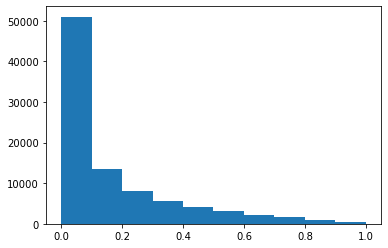

(90723,) (90723,)


In [29]:
#bkg_18 = data_dir + 'DY_18_sel.root'
bkg_18 = data_dir + 'TT_18_sel.root'
#bkg_18 = data_dir + 'other_18_sel.root'

X_train_bkg18, y_train_bkg18, m_train_bkg18, wtrainbkg, X_test_bkg18, y_test_bkg18, m_test_bkg18,wtestbkg, var_name_bkg18 = load_data(bkg_18, allBranches, inFeatures, isSig = False , preproc = True)

#pred_bkg_base = np.concatenate((ClassifierModelBase.predict(X_train[y_train==0]), ClassifierModelBase.predict(X_test[y_test==0])), axis=0)
#pred_bkg_dann = np.concatenate((ClassifierModel.predict(X_train[y_train==0]), ClassifierModel.predict(X_test[y_test==0])), axis=0)

pred_bkg_base = np.concatenate((ClassifierModelBase.predict(X_train_bkg18), ClassifierModelBase.predict(X_test_bkg18)), axis=0)
pred_bkg_dann = np.concatenate((ClassifierModel.predict(X_train_bkg18), ClassifierModel.predict(X_test_bkg18)), axis=0)

# retrieve actual analysis NN for comparison
                               
rfile = ROOT.TFile(bkg_18)
intree = rfile.Get('HTauTauTree')
arr = tree2array(intree,branches=['DNNoutSM_kl_1', 'HHKin_mass_raw'])
df = pd.DataFrame(arr)
df = df[df.HHKin_mass_raw>0]
pred_bkg_ana = df.DNNoutSM_kl_1[df.HHKin_mass_raw<1500]
print(pred_bkg_ana.shape)                               

plt.hist(pred_bkg_ana)
plt.show()
                               
y_bkg = np.concatenate((y_train_bkg18[y_train_bkg18==0],y_test_bkg18[y_test_bkg18==0]),axis=0)

print(y_bkg.shape, pred_bkg_ana.shape)
#pred_bkg_base.shape

### Retrieve predictions for all signal mass points

In [30]:
#sig_mass = np.array(['250', '260', '270', '280', '320', '350', '450', '500', '550', '600', '800', '900']) # all periods available
sig_mass = np.array(['250', '260', '270', '280', '300', '320', '350', '400', '450', '500', '550', '600', '650', '700', '750', '800', '850', '900']) # only some periods, todo: add list here

sig_sample = np.array([(data_dir+'Radion'+mass+'_2018_aresDNN_selAna.root') for mass in sig_mass])
#sig_sample = np.array([(data_dir+'Graviton'+mass+'_2018_resDNN_selAna.root') for mass in sig_mass])

sig_X_train, sig_y_train, sig_m_train = [], [], []
sig_X_test,  sig_y_test,  sig_m_test  = [], [], []
sig_var_names = []

for sample in sig_sample:
    X_train_tmp, y_train_tmp, m_train_tmp, wtrainsig, X_test_tmp, y_test_tmp, m_test_tmp, wtestsig, var_name_tmp = load_data(sample, allBranches, inFeatures, isSig = True, preproc = True)
    
    sig_X_train.append(np.array(X_train_tmp))
    sig_y_train.append(np.array(y_train_tmp))
    sig_m_train.append(np.array(m_train_tmp))
    sig_X_test.append(np.array(X_test_tmp))
    sig_y_test.append(np.array(y_test_tmp))
    sig_m_test.append(np.array(m_test_tmp))
    sig_var_names.append(np.array(var_name_tmp))


sig_X_train = np.array(sig_X_train, dtype=object)
sig_y_train = np.array(sig_y_train, dtype=object)
sig_m_train = np.array(sig_m_train, dtype=object)
sig_X_test = np.array(sig_X_test, dtype=object)
sig_y_test = np.array(sig_y_test, dtype=object)
sig_m_test = np.array(sig_m_test, dtype=object)
sig_var_names = np.array(sig_var_names)

X_sig = np.array([ np.concatenate((sig_X_train[i],sig_X_test[i]), axis=0) for i in range(len(sig_X_train)) ], dtype=object)
y_sig = np.array([ np.concatenate((sig_y_train[i],sig_y_test[i]), axis=0) for i in range(len(sig_y_train)) ], dtype=object)

print(y_sig[0].shape)
pred_dann = np.array([np.array(ClassifierModel.predict(sig)) for sig in X_sig], dtype=object)

pred_base = np.array([np.array(ClassifierModelBase.predict(sig)) for sig in X_sig], dtype=object)

pred_sig = []
for sample in sig_sample:
    rfile = ROOT.TFile(sample)
    intree = rfile.Get('HTauTauTree')
    arr = tree2array(intree,branches=['DNNoutSM_kl_1','HHKin_mass_raw'])
    df = pd.DataFrame(arr)
    df = df[df.HHKin_mass_raw>0]
    df = df[df.HHKin_mass_raw<1500]
    pred_sig.append(df.DNNoutSM_kl_1)
pred_ana = np.array(pred_sig, dtype=object)
print(pred_ana[0].shape)

TypeError: tree must be a ROOT.TTree

Error in <TFile::TFile>: file /data_CMS/cms/portales/HHresonant_SKIMS/trimmed_samples/Radion250_2018_aresDNN_selAna.root does not exist


### Compare signal/backgrounds predictions

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(20,9))


axs[0].hist(pred_bkg_dann, bins=10, density=True, alpha=0.5, label='TT')
for i in range(len(sig_mass)):
    axs[0].hist(pred_dann[i], bins=10, density=True, alpha=0.5 , label='m'+sig_mass[i])
axs[0].set_title('DANN output')
axs[0].legend( loc='best')
axs[0].set_yscale('log')

axs[1].hist(pred_bkg_base, bins=10, density=True, alpha=0.5, label='TT')
for i in range(len(sig_mass)):
    axs[1].hist(pred_base[i], bins=10, density=True, alpha=0.5 , label='m'+sig_mass[i])
axs[1].set_title('Base classifier output')
axs[1].legend(loc='best')
axs[1].set_yscale('log')

plt.show()

### Get ROC and Precision-Recall curves

In [ ]:
fpr_base, tpr_base, thresholds_base = [], [], []
fpr_dann, tpr_dann, thresholds_dann = [], [], []
fpr_ana,  tpr_ana,  thresholds_ana  = [], [], []

AUC_base, AUC_dann, AUC_ana = [], [], []

pre_base, rec_base, thresh_base = [], [], []
pre_dann, rec_dann, thresh_dann = [], [], []
pre_ana,  rec_ana,  thresh_ana  = [], [], []

for i in range(len(X_sig)):
    fpr_tmp, tpr_tmp, thresholds_tmp = roc_curve(np.concatenate((y_sig[i],y_bkg),axis=0), np.concatenate((pred_base[i], pred_bkg_base), axis=0))
    fpr_base.append(fpr_tmp)
    tpr_base.append(tpr_tmp)
    thresholds_base.append(thresholds_tmp)
    AUC_base.append(auc(fpr_tmp,tpr_tmp))
    
    fpr_tmp, tpr_tmp, thresholds_tmp = roc_curve(np.concatenate((y_sig[i],y_bkg),axis=0), np.concatenate((pred_dann[i], pred_bkg_dann), axis=0))
    fpr_dann.append(fpr_tmp)
    tpr_dann.append(tpr_tmp)
    thresholds_dann.append(thresholds_tmp)
    AUC_dann.append(auc(fpr_tmp,tpr_tmp))
    
    fpr_tmp, tpr_tmp, thresholds_tmp = roc_curve(np.concatenate((y_sig[i],y_bkg),axis=0), np.concatenate((pred_ana[i], pred_bkg_ana), axis=0))
    fpr_ana.append(fpr_tmp)
    tpr_ana.append(tpr_tmp)
    thresholds_ana.append(thresholds_tmp)
    AUC_ana.append(auc(fpr_tmp,tpr_tmp))
        
    pre_tmp, rec_tmp, thresh_tmp = precision_recall_curve(np.concatenate((y_sig[i],y_bkg),axis=0), np.concatenate((pred_base[i], pred_bkg_base), axis=0))
    pre_base.append(pre_tmp)
    rec_base.append(rec_tmp)
    thresh_base.append(thresh_tmp)
    
    pre_tmp, rec_tmp, thresh_tmp = precision_recall_curve(np.concatenate((y_sig[i],y_bkg),axis=0), np.concatenate((pred_dann[i], pred_bkg_dann), axis=0))
    pre_dann.append(pre_tmp)
    rec_dann.append(rec_tmp)
    thresh_dann.append(thresh_tmp)
    
    pre_tmp, rec_tmp, thresh_tmp = precision_recall_curve(np.concatenate((y_sig[i],y_bkg),axis=0), np.concatenate((pred_ana[i], pred_bkg_ana), axis=0))
    pre_ana.append(pre_tmp)
    rec_ana.append(rec_tmp)
    thresh_ana.append(thresh_tmp)
    

### Draw ROC and Precision-Recall curves

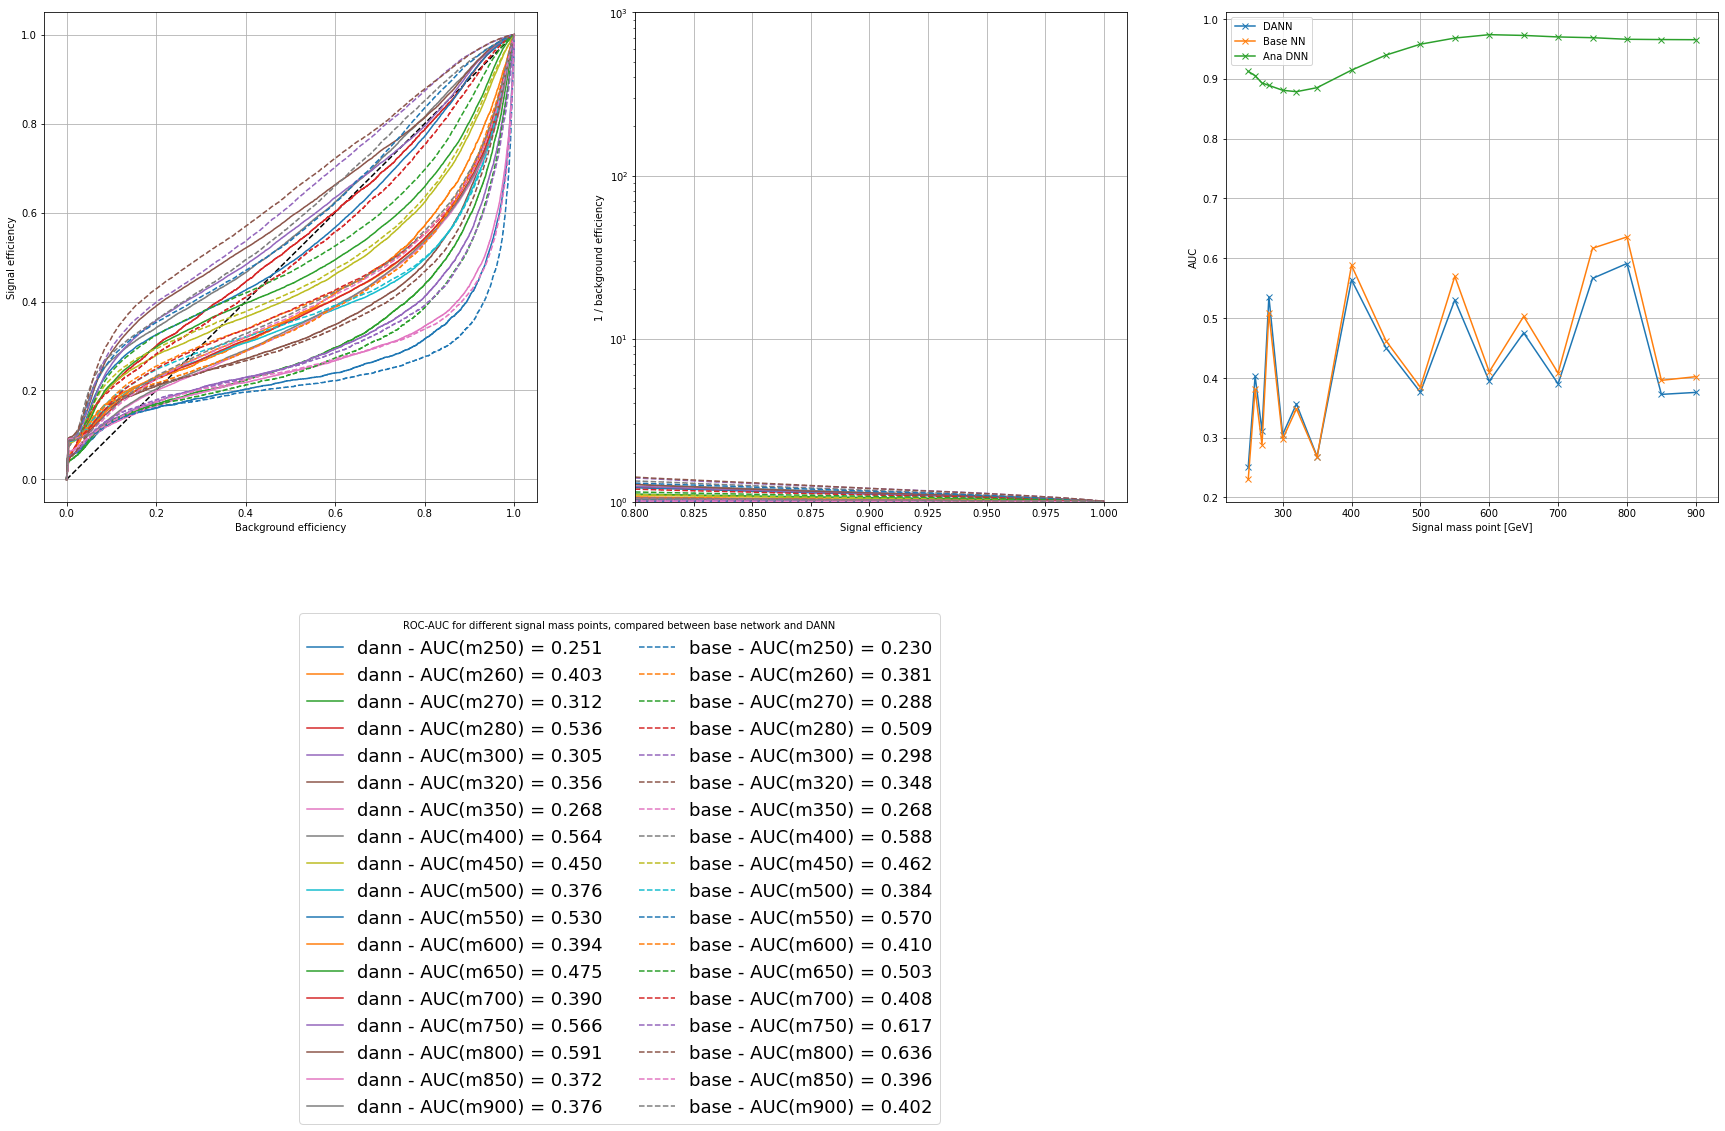

In [31]:

fig, axs = plt.subplots(1, 3,figsize=(30,9))

axs[0].plot([0,1],[0,1],'k--')

# plot the DANN curves
for i in range(len(sig_mass)):
    axs[0].plot(fpr_dann[i],tpr_dann[i], label='dann - AUC(m{0}) = {1:.3f}'.format(sig_mass[i], float(AUC_dann[i])),)
    #axs[1].plot(rec_dann[i],pre_dann[i], label='dann - m{0}'.format(sig_mass[i]))
    axs[1].plot(tpr_dann[i],1/(np.array(fpr_dann[i])+1e-10), label='dann - m{0}'.format(sig_mass[i]))

# reset pyplot color cycle    
axs[0].set_prop_cycle(None)
axs[1].set_prop_cycle(None)

# plot the base NN curves
for i in range(len(sig_mass)):
    axs[0].plot(fpr_base[i],tpr_base[i], label='base - AUC(m{0}) = {1:.3f}'.format(sig_mass[i], float(AUC_base[i])), linestyle='dashed')
    #axs[1].plot(rec_base[i],pre_base[i], label='base - m{0}'.format(sig_mass[i]), linestyle='dashed')
    axs[1].plot(tpr_base[i],1/(np.array(fpr_base[i])+1e-10), label='base - m{0}'.format(sig_mass[i]), linestyle='dashed')
    
# nicer ROC plot    
axs[0].set_xlabel('Background efficiency')
axs[0].set_ylabel('Signal efficiency')
axs[0].grid(True)
axs[0].legend(loc='center left', bbox_to_anchor=(.5, -.75), prop={'size': 18}, ncol=2, title='ROC-AUC for different signal mass points, compared between base network and DANN')

# nicer Precision/Recall plot
axs[1].grid(True)
axs[1].set_xlabel('Signal efficiency')
#axs[1].set_ylabel('Signal purity')
axs[1].set_yscale('log')
axs[1].set_xlim(0.8,1.01)
axs[1].set_ylim(1,1e3)
axs[1].set_ylabel('1 / background efficiency')

# plot AUC vs mass
axs[2].plot([int(i) for i in sig_mass], AUC_dann, label='DANN',    marker='x')
axs[2].plot([int(i) for i in sig_mass], AUC_base, label='Base NN', marker='x')
axs[2].plot([int(i) for i in sig_mass], AUC_ana,  label='Ana DNN', marker='x')

# nicer AUC vs mass
axs[2].set_xlabel('Signal mass point [GeV]')
axs[2].set_ylabel('AUC')
axs[2].grid(True)
axs[2].legend(loc='best')

plt.show()